<a href="https://colab.research.google.com/github/Yash-11/are/blob/main/are.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTRUCTIONS

**Use 'ctrl+]' to collapse all** if running in Google Colab

Steps to be followed

1. Mount your drive containing data.
2. Set 'prjct_dir' and 'data_dir' arguments in argparser. 
3. Run all cells before "Final results" section.
4. Run the exp(experiment) required in "Final results" section. 

Note: Arguments except 'prjct_dir' and 'data_dir' will be set automatically according to selected exp in "Final results"
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# ARGPARSE

In [ ]:
import torch
import argparse
parser = argparse.ArgumentParser('ARE')

"""
Change directory path 
prjct_dir: saving weights and results 
data_dir: data 
"""
prjct_dir = '../content/drive/My Drive/Colab Notebooks/are'
data_dir = '../content/drive/My Drive/Data/are_data'

parser.add_argument('--prjct_dir', type=str, default=prjct_dir)
parser.add_argument('--data_dir', type=str, default=data_dir)

parser.add_argument('--exp', type=str, choices=['mthd__snsr', 'snsr__seq_len', 'mthd__snr', 
                                                'mthd__tr_samp', 'mthd__bn',
                                                'rndm_trials', 'mthd__snsr_with_noise'], default='mthd__snsr')
parser.add_argument('--data_type', type=str, choices=['periodic', 'transient', 'sea_temp', 'turbulence'], default='turbulence')
# non_int.parse_known_args()
parser.add_argument('--operation_mode', type=str, choices=['offline', 'online'], default='online')  
parser.add_argument('--RNN', type=str, choices=['lstm', 'rnn'], default='lstm')
parser.add_argument('--gpu', type=int, default=0)
args = parser.parse_args("")

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
pip install cmocean

     |████████████████████████████████| 225kB 30.0MB/s 


In [ ]:
import pdb
import pandas as pd
import numpy as np
import scipy.linalg as la

import os
import os.path as osp

import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable

import matplotlib.pyplot as plt
import cmocean
import time
import random
from itertools import count
from itertools import chain
from skimage.transform import resize

In [ ]:
def get_path(method, string, **kwargs):
  """ 
  determine path to directory based upon string
  e.g. W=1 in kwargs return path of dir. to save weights

  :returns: path to directory
  """

  dir1 = args.data_type
  dir2 = args.exp
  dir3 = osp.join(method, args.operation_mode, args.RNN) if method == 'are' else method
  if args.exp == 'mthd__tr_samp':
     if hasattr(args, 'tr_samp'): add = 'tr_samp{}'.format(args.tr_samp)  
     else: raise Exception('number of training samples are required')

  if string == 'W':
      path = osp.join(args.prjct_dir, 'weights_results', dir1, dir2, dir3)

  elif string == 'W_AE':
      path = osp.join(args.prjct_dir, 'weights_results', dir1, dir2, method, 'autoencoder')

  elif string == 'I':
      path = osp.join(args.prjct_dir, 'weights_results', dir1, dir2, dir3)

  elif string == 'P':
      path = osp.join(args.prjct_dir, 'weights_results', dir1, dir2)

  else:
    raise ValueError('type of path not recongnized')

  path = osp.join(path, add) if args.exp == 'mthd__tr_samp' else path
  path = osp.join(path, kwargs.get('add_dir')) if kwargs.get('add_dir') else path
  if not os.path.exists(path):
      os.makedirs(path)

  return path

def get_name(method, string, **kwargs):
  """ 
  determine name of file 
  e.g. W=1 in kwargs return name of file of autoencoder weights

  :returns: path to directory
  """

  if string == 'W':

    sensor_number = kwargs.get('sensor_number')
    seq_len = kwargs.get('seq_len')
    bottle_neck = kwargs.get('bottle_neck')

    if method == 'are':
      return 'weights_s{}_sq{}_bn{}'.format(sensor_number, seq_len, bottle_neck) 

    elif method == 'pds':
      return 'weights_s{}_bn{}'.format(sensor_number, bottle_neck)

    elif method == 'sd':
      if kwargs.get('drop'):
        return 'weights_s{}_drop'.format(sensor_number)
      else:
        return 'weights_s{}'.format(sensor_number)

  elif string == 'W_AE':

    bn = kwargs.get('bottle_neck')
    dropout = kwargs.get('drop')
    
    if dropout:
      return 'weights_bn{}_drop{}'.format(bn, dropout)
    else:
      return 'weights_bn{}'.format(bn)

In [ ]:
def get_data():
  """ 
  load data from data_dir
  data is strored in args.raw_data
  """
  path_data = args.data_dir

  if hasattr(args, 'raw_data') and hasattr(args, 'last_data_type') and args.data_type == args.last_data_type:

    print('using previously loaded data')

  else:

    start_time = time.time()
    if args.data_type == 'transient':
      print('loading transient flow past cylinder data...')
      td180 = np.load(osp.join(path_data, 'data180.npy'))
      td190 = np.load(osp.join(path_data, 'data190.npy'))
      td200 = np.load(osp.join(path_data, 'data200.npy'))
      td185 = np.load(osp.join(path_data, 'data185.npy'))
      td195 = np.load(osp.join(path_data, 'data195.npy'))
      args.raw_data = (td180, td190, td200, td185, td195)
      print('data loaded')

    elif args.data_type == 'periodic':
      args.raw_data = np.load(osp.join(path_data, 'data190+.npy'))
      print('data loaded')

    elif args.data_type == 'turbulence':
      args.raw_data = np.load(osp.join(path_data, 'tb_128_5000.npy'))
      print('data loaded')
    
    elif args.data_type == 'sea_temp':
      land_sea = np.load(osp.join(path_data, 'SSTdata1990.npz'))['arr_0']

      t = land_sea[0]
      n_pixel = len(t)
      len_data = len(land_sea[:, 0])
      land_pos = np.where(t > 1e+30)[0] 

      full_idx = np.arange(n_pixel)
      args.sea_idx = np.delete(full_idx, land_pos)
      args.raw_data = np.delete(land_sea, [land_pos], 1)
      print('data loaded')

    else:
      print('data_type is not recognised')

    print("--- %s seconds --" % (time.time() - start_time))  
    args.last_data_type = args.data_type


In [ ]:
def mn(**kwargs):
  """ returns data image dimentions """

  if args.data_type == 'periodic':
    m, n = 251, 168
  if args.data_type == 'transient':
    m, n = 502, 252
  if args.data_type == 'turbulence':
    m, n = 128, 128
  if args.data_type == 'sea_temp':
    m, n = 360, 180
  
  return m,n


def sensor_cord_data(sensor_num):
  """ sensor pixel co-ordinates for all data_types
  :returns: numpy array of shape (no_sensors, 2) with integer values
  """
  m, n = mn()

  if args.data_type == 'periodic':

    theata = np.linspace(0, 2*np.pi, 300)
    x_cord = np.round(25 * np.cos(theata)) + 0
    y_cord = np.round(25 * np.sin(theata)) + n/2
    cords_ = np.vstack((x_cord,y_cord)).T
    cords_ = np.unique(cords_, axis=0)
    idx = cords_[:,0] > 0
    cords_ = cords_[idx,:]
    np.random.seed(3265)  # changing seed will change the postion of sensors and networks will have to be retrained
    idx = np.random.choice(range(cords_.shape[0]), sensor_num, False)
    cords = np.int64(cords_[idx,:])

    mask = np.zeros((m,n))
    mask[cords[:,0], cords[:,1]] = 1
    s_idx_in_flatten = np.where(mask.reshape(-1) == 1)
    s_idx_in_flatten = np.asarray(s_idx_in_flatten).ravel()

  elif args.data_type == 'transient':

    theata = np.linspace(0, 2*np.pi, 300)
    x_cord = np.round(24 * np.cos(theata)) + 0
    y_cord = np.round(24 * np.sin(theata)) + n/2
    cords_ = np.vstack((x_cord,y_cord)).T
    cords_ = np.unique(cords_, axis=0)
    idx = cords_[:,0] > 0
    cords_ = cords_[idx,:]
    np.random.seed(323)  # changing seed will change the postion of sensors and networks will have to be retrained
    idx = np.random.choice(range(cords_.shape[0]), sensor_num, False)
    cords = np.int64(cords_[idx,:])

    mask = np.zeros((m,n))
    mask[cords[:,0], cords[:,1]] = 1
    s_idx_in_flatten = np.where(mask.reshape(-1) == 1)
    s_idx_in_flatten = np.asarray(s_idx_in_flatten).ravel()

  elif args.data_type == 'turbulence':

    # x = np.tile(np.arange(0, 32), 32)[:, np.newaxis]
    # y = np.repeat(np.arange(0, 32), 32, axis=0)[:, np.newaxis]
    # cords = np.concatenate((x, y), axis=1)*4 + 2

    # mask = np.zeros((m,n))
    # mask[cords[:,0], cords[:,1]] = 1
    # s_idx_in_flatten = np.where(mask.reshape(-1) == 1)
    # s_idx_in_flatten = np.asarray(s_idx_in_flatten).ravel()
    # plt.scatter(cord[:,0], cord[:, 1])
    s_idx_in_flatten = cords = None

  elif args.data_type == 'sea_temp': 

    idices = np.arange(0, 44219)
    np.random.seed(73)  #323 21 23 changing seed will change the postion of sensors and networks will have to be retrained
    s_idx_in_flatten = np.random.choice(idices, sensor_num, False)

    flat_sea_mask = np.zeros((44219))
    flat_sea_mask[s_idx_in_flatten] = 1
    flat_mask = np.zeros((m*n))
    for i, j in zip(args.sea_idx, count(0, 1)):
      flat_mask[i] = flat_sea_mask[j]

    mask = flat_mask.reshape(n, m)
    cords = np.where(mask == 1)
    cords = np.asarray(cords)

    # plt.figure()
    # plt.scatter(cords[1], cords[0])
    # plt.show()
  
  return s_idx_in_flatten, cords

In [ ]:
def image_select(method, i, images, s, plot, save, **kwargs):

  seq_len = kwargs.get('seq_len')
  if method == 'are':
    seq_impct = (kwargs.get('seq_len')-1)//2 
    add1 = '_sq{}_i{}'.format(seq_len, i+seq_impct, args.RNN)  
  else:
    seq_impct = 0
    add1 =  ''
  add2 = '_SNR{}'.format(kwargs.get('SNR', '')) if args.exp == 'mthd__snr' else ''
  name = ('im_{}_{}_{}_s{}'.format(args.data_type, args.exp, method, s) + add1 + add2, 
          'im_true_{}_{}_{}_s{}'.format(args.data_type, args.exp, method, s) + add1 + add2)
        
  SNR = kwargs.get('SNR')
  if s in kwargs.get('plot_s_list', [None]):
    if seq_len in kwargs.get('plot_seq_len_list', [None]):
      if SNR in kwargs.get('plot_SNR', [None]):
        if i in kwargs.get('plot_image_idx', [None])-seq_impct:
          show_save_image(method,
                          images,
                          plot,
                          save, 
                          name=name,
                          i=i,
                          **kwargs)


def show_save_image(method, images, plot, save, **kwargs):

  istupl = True if isinstance(images, tuple) else False

  len_tuple = len(images) if istupl else 1
  get_value = lambda index, tuple_ : tuple_[index] if istupl else tuple_
  i = kwargs.get('i', 0)
  stats = kwargs.get('stats', np.array([0]))

  if istupl:
    assert len_tuple == len(save) == len(plot)
    if any(save):
      assert len(kwargs.get('name')) == len_tuple, 'mention all names of images for saving'
  else:
    if save: assert kwargs.get('name') 

  for idx in range(len_tuple):
      
    save_ = get_value(idx, save)
    plot_ = get_value(idx, plot)
    name = get_value(idx, kwargs.get('name', ['im']*len_tuple))

    cords = kwargs.get('cords', np.array([0]))

    t = get_value(idx, images)
    t = t.cpu().data.numpy() if torch.is_tensor(t) else t
    if t.ndim == 1:
      t = t
    elif t.ndim == 2:
      t = t[-1]
    elif t.ndim == 3:
      t = t[-1, -1]
    t = t * stats[1, :] + stats[0, :] if stats.any() else t

    ny, nx = m, n = mn()
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)

    if args.data_type == 'periodic' or args.data_type == 'transient':

      t_ = t.reshape((ny, nx))
      print('reconstruction',i)
      minmax = np.max(np.abs(t_)) * 0.65
      plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      im = plt.imshow(t_.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      if kwargs.get('contour', 1): 
        try:
          plt.contourf(mX, mY, t_.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3) 
        except:
          plt.contourf(mX, mY, t_.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax) 
      plt.scatter(cords[:,0], cords[:,1], marker='.', color='#ff7f00', s=500, zorder=5) if cords.any() else 0

    if args.data_type == 'turbulence':

      t_ = t.reshape((ny, nx))
      print('reconstruction',i)
      plt.figure(facecolor="white",  edgecolor='k')
      im = plt.imshow(t_)
      
    if args.data_type == 'sea_temp':

      print('reconstruction',i)
      recon = np.ones((m*n))*35
      for i, j in zip(args.sea_idx, count(0, 1)):
        recon[i] = t[j]

      recon_im = recon.reshape(n, m)

      plt.figure()
      plt.imshow(recon_im, cmap='terrain')
      plt.gca().invert_yaxis()
      plt.scatter(cords[1], cords[0], marker='.', color='b', s=20, zorder=5) if cords.any() else 0
      plt.axis('off')

    if save_:
      path = kwargs.get('path') if kwargs.get('path') else get_path(method, 'I') 
      plt.savefig(osp.join(path, '{}.pdf'.format(name)), format='pdf')
      print('SAVED ==', osp.join(path, '{}.pdf'.format(name)))
    
    plt.show() if plot_ else 0
        

In [ ]:
def plot_graph(rerror_train, rerror_test, save, name):
    fig = plt.figure()
    plt.plot(rerror_train, lw=2, label='Trainings error', color='#377eb8',)  
    plt.plot(rerror_test, lw=2, label='Valid error', color='#e41a1c',)            
    plt.tick_params(axis='x', labelsize=14) 
    plt.tick_params(axis='y', labelsize=14) 
    plt.locator_params(axis='y', nbins=10)
    plt.locator_params(axis='x', nbins=10)
    
    plt.ylabel('Error', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.grid(False)
    plt.yscale("log")
    plt.legend(fontsize=14)
    fig.tight_layout()

    if save:
      plt.savefig(name, format='png')


In [ ]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power 
    spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
"""
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

# td_n2 = np.zeros((300,42168))
# # td_n2 = awgn(td,10)
# for i in range(len(td)):
#   td_n2[i,:] = awgn(td[i],1)

#**NETWORKS**

## Autoencoder Net

In [ ]:
class autoencoder(nn.Module):
    def __init__(self,bottle_neck, **kwargs):
        super(autoencoder, self).__init__()
        m, n = mn()
        k = m*n
        drop = kwargs.get('drop')

        if args.data_type == 'transient':

            if drop:
              print('autoencoder oprating with dropout:', drop)
              self.encoder = nn.Sequential(
                  # nn.Dropout(p =0.5),
                  nn.Linear(k, 2000),
                  nn.BatchNorm1d(num_features = 2000),
                  nn.ReLU(True),
                  # nn.Dropout(p =0.5),
                  nn.Linear(2000, 300),
                  nn.BatchNorm1d(num_features =300),
                  nn.ReLU(True),
                  nn.Dropout(p=drop),
                  nn.Linear(300, bottle_neck))
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 300),
                  nn.ReLU(True),
                  nn.Linear(300, 2000),       
                  nn.ReLU(True),
                  nn.Linear(2000, k)) 

            else:
              print('autoencoder oprating without dropout layer')
              self.encoder = nn.Sequential(
                  nn.Linear(k, 2000),
                  nn.ReLU(True),
                  nn.Linear(2000, 300), 
                  nn.ReLU(True),
                  nn.Linear(300, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 300),
                  nn.ReLU(True),
                  nn.Linear(300, 2000),
                  nn.ReLU(True),
                  nn.Linear(2000, k)) 

        elif args.data_type == 'periodic':

            if drop:
              print('autoencoder oprating with dropout:', drop)
              self.encoder = nn.Sequential(
                  nn.Linear(k, 1024),
                  nn.BatchNorm1d(num_features = 1024),
                  nn.ReLU(True),
                  nn.Linear(1024, 256),
                  nn.BatchNorm1d(num_features =256), 
                  nn.ReLU(True),
                  nn.Dropout(p=drop),
                  nn.Linear(256, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 256),
                  nn.ReLU(True),
                  nn.Linear(256, 1024),          
                  nn.ReLU(True),
                  nn.Linear(1024, k)) 
            else:
              print('autoencoder oprating without dropout layer')
              self.encoder = nn.Sequential(
                  nn.Linear(k, 1024),
                  nn.ReLU(True),
                  nn.Linear(1024, 256),
                  nn.ReLU(True),
                  nn.Linear(256, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 256),
                  nn.ReLU(True),
                  nn.Linear(256, 1024),
                  nn.ReLU(True),
                  nn.Linear(1024, k)) 
              
        elif args.data_type == 'turbulence':

            if drop:
              print('autoencoder oprating with dropout:', drop)
              self.encoder = nn.Sequential(
                  nn.Linear(k, 512),
                  nn.BatchNorm1d(num_features = 512),
                  nn.ReLU(True),
                  nn.Linear(512, 256),
                  nn.BatchNorm1d(num_features =256), 
                  nn.ReLU(True),
                  nn.Dropout(p=drop),
                  nn.Linear(256, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 256),
                  nn.ReLU(True),
                  nn.Linear(256, 512),          
                  nn.ReLU(True),
                  nn.Linear(512, k)) 
            else:
              print('autoencoder oprating without dropout layer')
              self.encoder = nn.Sequential(
                  nn.Linear(k, 512),
                  nn.BatchNorm1d(num_features=512),
                  nn.ReLU(True),
                  nn.Linear(512, 256),
                  nn.BatchNorm1d(num_features=256),
                  nn.ReLU(True),
                  nn.Linear(256, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 256),
                  nn.BatchNorm1d(num_features=256),
                  nn.ReLU(True),
                  nn.Linear(256, 512),
                  nn.BatchNorm1d(num_features=512),
                  nn.ReLU(True),
                  nn.Linear(512, k)) 
              
        elif args.data_type == 'sea_temp':
            k = 44219

            if drop:
              print('autoencoder oprating with dropout:', drop)
              self.encoder = nn.Sequential(
                  nn.Linear(k, 512),
                  nn.BatchNorm1d(num_features=512),
                  nn.ReLU(True),
                  nn.Linear(512, 256),
                  nn.BatchNorm1d(num_features=256), 
                  nn.ReLU(True),
                  nn.Dropout(p=drop),
                  nn.Linear(256, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 256),
                  nn.ReLU(True),
                  nn.Linear(256, 512),          
                  nn.ReLU(True),
                  nn.Linear(512, k)) 
            else:
              print('autoencoder oprating without dropout layer')
              self.encoder = nn.Sequential(
                  nn.Linear(k, 512),
                  # nn.BatchNorm1d(num_features = 512),
                  nn.ReLU(True),
                  nn.Linear(512, 256),
                  # nn.BatchNorm1d(num_features =256), 
                  nn.ReLU(True),
                  nn.Linear(256, bottle_neck)) 
              self.decoder = nn.Sequential(
                  nn.Linear(bottle_neck, 256),
                  # nn.BatchNorm1d(num_features =256),
                  nn.ReLU(True),
                  nn.Linear(256, 512),
                  # nn.BatchNorm1d(num_features =512),
                  nn.ReLU(True),
                  nn.Linear(512, k)) 

    def forward(self, x):
      # pdb.set_trace()
      try :
        w = self.decoder(x)
        return w
      except :
        y = self.encoder(x)
        z = self.decoder(y)
        return z,y
        

## PDS net

In [ ]:
class PDSnetwork(nn.Module):

    def __init__(self, sensor_number, bottle_neck):
        super(PDSnetwork, self).__init__()

        if args.data_type == 'transient':
          H = 200
        if args.data_type == 'periodic':
          H = 50
        if args.data_type == 'turbulence':
          H = 150
        if args.data_type == 'sea_temp':
          H = 100

        self.l1 = nn.Linear(sensor_number, H)
        self.l2 = nn.Linear(H, H)
        self.output = nn.Linear(H, bottle_neck)

    def forward(self, leading_dna):
        l1_out = F.relu(self.l1(leading_dna))
        l2_out = F.relu(self.l2(l1_out))
        output = self.output(l2_out)        
        return output

## RNN Net

In [ ]:
if args.data_type == 'transient':   
  class are_rnn_net(nn.Module):

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len,**kwargs):
          super(are_rnn_net, self).__init__()
          self.hidden_size = hidden_size
          # self.AREdrop = kwargs.get('AREdrop',None)
          print('args.data_type == transient', '\n', 'using rnn cell')

          if args.operation_mode == 'online':      
            self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(hidden_size, 200, bias=True)

          elif args.operation_mode == 'offline':
            self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.rlr = nn.LSTM(sensor_number, self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(hidden_size*2, 200, bias=True)

          
          self.l2 = nn.Linear(200, 200, bias=True)
          self.l3 = nn.Linear(200, bottle_neck, bias=True)
          
          # self.bn_25 = nn.BatchNorm1d(num_features=25)
          #self.reset_hidden_states()


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          if args.operation_mode == 'online':    
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)

          if args.operation_mode == 'offline':
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rlr_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)
            self.rlr_c = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device
              if args.operation_mode == 'online':    
                self.rl_h = self.rl_h.to(device)
                self.rl_c = self.rl_c.to(device)
                
              if args.operation_mode == 'offline':
                self.rl_h = self.rl_h.to(device)
                self.rlr_h = self.rlr_h.to(device)
                self.rl_c = self.rl_c.to(device)
                self.rlr_c = self.rlr_c.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))


      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          #print(batch)
          sensor_number = len(leading_dna[0,0,:])
          #print(sensor_number)
          seq_len = len(leading_dna[:,0,0])
          #print(seq_len)
          seq_impct = int((seq_len-1)/2)

          if args.operation_mode == 'online':    
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] 

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            r_out = rl_out[seq_impct]  


          if args.operation_mode == 'offline':
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
            split_data2 = leading_dna[seq_impct:seq_len,:,:]

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
            r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
            
          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))

if args.data_type == 'periodic':     
  class RNNv3network(nn.Module):

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len,**kwargs):
          super(RNNv3network, self).__init__()
          self.hidden_size = hidden_size
          # self.AREdrop = kwargs.get('AREdrop',None)
          print('args.data_type == periodic', '\n', 'using rnn cell')

          if args.operation_mode == 'online':      
            self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(hidden_size, 50, bias=True)


          if args.operation_mode == 'offline':
            self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.rlr = nn.LSTM(sensor_number, self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(hidden_size*2, 50, bias=True)

          
          self.l2 = nn.Linear(50, 50, bias=True)
          self.l3 = nn.Linear(50, bottle_neck, bias=True)
          
          # self.bn_25 = nn.BatchNorm1d(num_features=25)
          #self.reset_hidden_states()


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          if args.operation_mode == 'online':    
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)

          if args.operation_mode == 'offline':
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rlr_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)
            self.rlr_c = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device
              if args.operation_mode == 'online':    
                self.rl_h = self.rl_h.to(device)
                self.rl_c = self.rl_c.to(device)
                
              if args.operation_mode == 'offline':
                self.rl_h = self.rl_h.to(device)
                self.rlr_h = self.rlr_h.to(device)
                self.rl_c = self.rl_c.to(device)
                self.rlr_c = self.rlr_c.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))


      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          #print(batch)
          sensor_number = len(leading_dna[0,0,:])
          #print(sensor_number)
          seq_len = len(leading_dna[:,0,0])
          #print(seq_len)
          seq_impct = int((seq_len-1)/2)

          if args.operation_mode == 'online':    
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] 

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            r_out = rl_out[seq_impct]  


          if args.operation_mode == 'offline':
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
            split_data2 = leading_dna[seq_impct:seq_len,:,:]

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
            r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
            
          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))
                

## LSTM Net 

In [ ]:
 
class are_lstm_net(nn.Module):

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(are_lstm_net, self).__init__()
        self.hidden_size = hidden_size
        print('data_type:', args.data_type, '\n', 'using lstm cell')

        if args.data_type == 'transient': 

          self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)
          H = 200

          if args.operation_mode == 'online':      
            self.l1 = nn.Linear(hidden_size, H)
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

          if args.operation_mode == 'offline':
            self.rlr = nn.LSTM(sensor_number, self.hidden_size, num_layers=layers)
            self.l1 = nn.Linear(hidden_size*2, H)
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

        if args.data_type == 'periodic': 

          self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)
          H = 50
          
          if args.operation_mode == 'online':      
            self.l1 = nn.Linear(hidden_size, H)            
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

          if args.operation_mode == 'offline':
            self.rlr = nn.LSTM(sensor_number, self.hidden_size, num_layers=layers)
            self.l1 = nn.Linear(hidden_size*2, H)
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

        if args.data_type == 'turbulence': 

          self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)
          H = 150

          if args.operation_mode == 'online':      
            self.l1 = nn.Linear(hidden_size, H)            
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

          if args.operation_mode == 'offline':
            self.rlr = nn.LSTM(sensor_number, self.hidden_size, num_layers=layers)
            self.l1 = nn.Linear(hidden_size*2, H)
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

        if args.data_type == 'sea_temp': 

          self.rl = nn.LSTM(sensor_number , self.hidden_size, num_layers=layers)
          H = 100

          if args.operation_mode == 'online':      
            self.l1 = nn.Linear(hidden_size, H)
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

          if args.operation_mode == 'offline':
            self.rlr = nn.LSTM(sensor_number, self.hidden_size, num_layers=layers)
            self.l1 = nn.Linear(hidden_size*2, H)
            self.l2 = nn.Linear(H, H)
            self.l3 = nn.Linear(H, bottle_neck)

    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        if args.operation_mode == 'online':      
          self.rl_h = self.init_hidden(batch_size=batch_size)
          self.rl_c = self.init_hidden(batch_size=batch_size)

        if args.operation_mode == 'offline':
          self.rl_h = self.init_hidden(batch_size=batch_size)
          self.rlr_h = self.init_hidden(batch_size=batch_size)
          self.rl_c = self.init_hidden(batch_size=batch_size)
          self.rlr_c = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device

            if args.operation_mode == 'online':      
              self.rl_h = self.rl_h.to(device)
              self.rl_c = self.rl_c.to(device)

            if args.operation_mode == 'offline':
                self.rl_h = self.rl_h.to(device)
                self.rlr_h = self.rlr_h.to(device)
                self.rl_c = self.rl_c.to(device)
                self.rlr_c = self.rlr_c.to(device)


    def init_hidden(self, batch_size):
        layers =1
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))

    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)
        
        batch = len(leading_dna[0,:,0])
        sensor_number = len(leading_dna[0,0,:])
        seq_len = len(leading_dna[:,0,0])
        seq_impct = int((seq_len-1)/2)

        if args.operation_mode == 'online':      
          split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
          split_data1 = leading_dna[0:seq_impct+1,:,:] 

          rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
          r_out = rl_out[seq_impct]

        if args.operation_mode == 'offline':
          split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
          split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
          split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
          split_data2 = leading_dna[seq_impct:seq_len,:,:]

          rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
          rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
          r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)

        l1_out = F.relu(self.l1(r_out))
        l2_out = F.relu(self.l2(l1_out))
        out = l3_out = self.l3(l2_out)

        # if args.data_type == 'transient': 
        #   out = l3_out = self.l3(l2_out)

        # if args.data_type == 'periodic': 
        #   out = l3_out = self.l3(l2_out)

        return out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))


## Shallow Decoder Net

In [ ]:
class shallow_decoder_net(nn.Module):
    def __init__(self, n_sensors, **kwargs):
        super(shallow_decoder_net, self).__init__()
        
        m, n = mn()
        self.n_sensors = n_sensors
        self.outputlayer_size = m*n
        self.drop = kwargs.get('drop')

        if self.drop:
            print('shallow_decoder oprating with drop')
        else:
            print('shallow_decoder oprating without drop')

        if args.data_type == 'periodic':
          N1, N2 = 35, 40
        if args.data_type == 'transient':
          N1, N2 = 350, 400
        if args.data_type == 'turbulence':
          N1, N2 = 350, 400
        if args.data_type == 'sea_temp':
          N1, N2 = 350, 400
          self.outputlayer_size = 44219
        
        self.learn_features = nn.Sequential(         
            nn.Linear(n_sensors, N1),
            nn.ReLU(True), 
            nn.BatchNorm1d(1),  
            )        
        
        self.learn_coef = nn.Sequential(            
            nn.Linear(N1, N2),
            nn.ReLU(True),  
            nn.BatchNorm1d(1),  
            )

        self.learn_dictionary = nn.Sequential(
            nn.Linear(N2, self.outputlayer_size),
            )
        

        for m in self.modules():
            # torch.manual_seed(args.seed)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)        

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0.0)    


    def forward(self, x):
        x = self.learn_features(x)
        if self.drop:
            # torch.manual_seed(args.seed)
            x = nn.functional.dropout(x, p=0.1, training=self.training)   
        x = self.learn_coef(x)
        x = self.learn_dictionary(x) 
        return x

## Other RNN Net variants "Not used"

In [ ]:
""" Not used """

class RNNvnetwork(nn.Module):

    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(RNNv3network, self).__init__()
        self.hidden_size = hidden_size

        # Recurrent layers
        self.rl = nn.RNN(sensor_number , self.hidden_size, num_layers=layers, nonlinearity = 'relu')
        self.rlr = nn.RNN(sensor_number, self.hidden_size, num_layers=layers, nonlinearity = 'relu')

        # Final feed-forward layer
        self.l1 = nn.Linear(hidden_size*2, 500, bias=True)
        self.l2 = nn.Linear(500, 500, bias=True)
        self.l3 = nn.Linear(500, bottle_neck, bias=True)

    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        self.rlr_h = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)
            self.rlr_h = self.rlr_h.to(device)


    def init_hidden(self, batch_size):
        layers = 1
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)
        
        batch = len(leading_dna[0,:,0])
        sensor_number = len(leading_dna[0, 0, :])
        seq_len = len(leading_dna[:,0,0])
        seq_impct = int((seq_len-1)/2)

        split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data1 = leading_dna[0:seq_impct+1,:,:]  # (seq_impct+1,batch,sensor_number)
        split_data2 = leading_dna[seq_impct:seq_len,:,:]

        rl_out, self.rl_h = self.rl(split_data1, self.rl_h)
        rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), self.rlr_h)
        r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
        l1_out = F.relu(self.l1(r_out))
        l2_out = F.relu(self.l2(l1_out))
        l3_out = self.l3(l2_out)
        return l3_out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))


class RNNnetwork(nn.Module):

    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers):
        super(RNNnetwork, self).__init__()
        self.hidden_size = hidden_size

        # Recurrent layers
        self.rl = nn.RNN(sensor_number , self.hidden_size, num_layers=layers, nonlinearity = 'relu', dropout=self.DROPOUT)
        self.rlr = nn.RNN(sensor_number, self.hidden_size, num_layers=layers, nonlinearity = 'relu', dropout=self.DROPOUT)

        # Final feed-forward layer
        self.l1 = nn.Linear(hidden_size*2, 200, bias=True)
        self.l2 = nn.Linear(200, bottle_neck, bias=True)

    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        self.rlr_h = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)
            self.rlr_h = self.rlr_h.to(device)


    def init_hidden(self, batch_size):
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)

        rl_out, self.rl_h = self.rl(leading_dna, self.rl_h)
        rlr_out, self.rlr_h = self.rlr(self.flip_input(leading_dna), self.rlr_h)
        r_out = torch.cat((rl_out[1], rlr_out[1]), 1)
        l1_out = F.relu(self.l1(r_out))
        l2_out = self.l2(l1_out)
        return l2_out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))

class RNNv2network(nn.Module):
    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(RNNv2network, self).__init__()
        self.hidden_size = hidden_size
        
        # Recurrent layers
        self.rl = nn.RNN(sensor_number, self.hidden_size, num_layers= layers, nonlinearity = 'relu', dropout=self.DROPOUT, bidirectional =True)
        
        # Final feed-forward layer
        self.l1 = nn.Linear(hidden_size*2*seq_len, 200, bias=True)
        self.l2 = nn.Linear(200, bottle_neck, bias=True)

    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        
        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(layers*2, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)

        rl_out, self.rl_h = self.rl(leading_dna, self.rl_h)
        if seq_len == 3:
          r_out = torch.cat((rl_out[0], rl_out[1], rl_out[2]), 1)
        elif seq_len == 5:
          r_out = torch.cat((rl_out[0], rl_out[1], rl_out[2], rl_out[3], rl_out[4]), 1)
        elif seq_len == 7:
          r_out = torch.cat((rl_out[0], rl_out[1], rl_out[2], rl_out[3], rl_out[4], rl_out[5], rl_out[6]), 1)
        l1_out = F.relu(self.l1(r_out))
        l2_out = self.l2(l1_out)
        return l2_out


#**Pytorch custom DATASET class**

In [ ]:
class sensorgcdatasetAE(Dataset):

    def __init__(self, in_file, stats, transform=None):
        self.sensor_frame = in_file
        self.stats = stats
        self.transform = transform

    def __len__(self):
        return len(self.sensor_frame)

    def __getitem__(self, idx):
        sensor = self.sensor_frame[idx, :]
        sensor = (sensor - self.stats[0, :]) / self.stats[1, :]
        sensor = torch.from_numpy(sensor).float()
        return sensor

class sensorgcdatasetAA(Dataset):
    def __init__(self, in_file, out_file, stats, transform=None):
        self.sensor_frame = in_file
        self.gc_frame = out_file
        self.stats = stats
        self.transform = transform

    def __len__(self):
        return len(self.sensor_frame)

    def __getitem__(self, idx):
        sensor = self.sensor_frame[idx, :]
        gc = self.gc_frame[idx, :]
        gc = (gc - self.stats[0, :])/self.stats[1, :]
        sensor = torch.from_numpy(sensor).float()
        gc = torch.from_numpy(gc).float()
        return sensor, gc

class sensorgcdatasetRNN(Dataset):

    def __init__(self, in_file, out_file, transform=None):
        self.sensor_frame = in_file
        self.gc_frame = out_file
        self.transform = transform

    def __len__(self):
        return len(self.sensor_frame)

    def __getitem__(self, idx):
        sensor = self.sensor_frame[idx, :]
        gc = self.gc_frame[idx, :]
        sensor = torch.from_numpy(sensor).float()
        gc = torch.from_numpy(gc).float()
        return sensor, gc

class sensorgcdatasetDS(Dataset):

    def __init__(self, in_file, out_file, transform=None):
        self.in_frame = in_file
        self.out_frame = out_file
        self.transform = transform

    def __len__(self):
        return len(self.in_frame)

    def __getitem__(self, idx):
        inn = self.in_frame[idx, :]
        out = self.out_frame[idx, :]
        inn = torch.from_numpy(inn).float()
        out = torch.from_numpy(out).float()
        return inn, out

# **TRAIN/TEST DATA**

In [ ]:
def sensor_data(trainAE_stan, validAE_stan, testAE_stan, sensor_num):

  n_train, n_valid, n_test = trainAE_stan.shape[0], validAE_stan.shape[0], testAE_stan.shape[0]

  if args.data_type != 'turbulence':

    s_idx_in_flatten, cords = sensor_cord_data(sensor_num)

    strain_in = trainAE_stan[:, s_idx_in_flatten]
    svalid_in = validAE_stan[:, s_idx_in_flatten]
    stest_in = testAE_stan[:, s_idx_in_flatten]

  else:

    sqrt_s = int(sensor_num**0.5)
    strain_in = (resize(trainAE_stan, (n_train, sqrt_s, sqrt_s))).reshape(n_train, sensor_num)
    svalid_in = (resize(validAE_stan, (n_valid, sqrt_s, sqrt_s))).reshape(n_valid, sensor_num)
    stest_in = (resize(testAE_stan, (n_test, sqrt_s, sqrt_s))).reshape(n_test, sensor_num)

  return strain_in, svalid_in, stest_in


def standardize(a, b, c, stats):

  a_stan = (a - stats[0, :])/stats[1, :]
  b_stan = (b - stats[0, :])/stats[1, :]
  c_stan = (c - stats[0, :])/stats[1, :]
  
  return a_stan, b_stan, c_stan 

## Autoencoder_train_data

In [ ]:
def autoencoder_train_data(**kwargs):
  
  noisy_data = SNR = kwargs.get('SNR')
  plot, save = kwargs.get('plot'), kwargs.get('save')

  if args.data_type == 'periodic': 

    get_data()
    td = args.raw_data  
    m, n = mn()
    tr_samp = args.tr_samp if hasattr(args, 'tr_samp') else 180

    if noisy_data:
      print('in autoencoder_train_data-- noise data', 'SNR: ', SNR)
      
      td_ = np.zeros_like(td)
      for i in range(len(td)):
        td_[i,:] = awgn(td[i],kwargs.get('SNR',10))

      image, name = td_[tr_samp+60:tr_samp+120,:][39,:], 'im_true_39_SNR{}'.format(SNR)
      if SNR in kwargs.get('plot_SNR', [0]): show_save_image('', image, plot, save, path=get_path('', 'P'), name=name, contour=0) 

    else :
      print('in autoencoder_train_data-- no noise data')
      td_ = td

    trainAE = td_[0:tr_samp,:]
    validAE = td_[tr_samp:tr_samp+60,:]
    testAE = td_[tr_samp+60:tr_samp+120,:]  
 

  elif args.data_type == 'transient':

    get_data()
    td180, td190, td200, td185, td195 = args.raw_data
    tr_samp = len(td180)*3

    if noisy_data:
      print('in autoencoder_train_data-- noise data', 'SNR =',SNR)
      
      td1_ = td2_ = td3_ = td4_ = td5_ = np.zeros_like(td180)
      for i in range(len(td1_)):
        td1_[i,:] = awgn(td180[i],SNR)
        td2_[i,:] = awgn(td190[i],SNR)
        td3_[i,:] = awgn(td200[i],SNR)
        td4_[i,:] = awgn(td185[i],SNR)
        td5_[i,:] = awgn(td195[i],SNR)
      image, name = td5_[335,:], 'im_true_335_SNR{}'.format(SNR)
      if SNR in kwargs.get('plot_SNR', [0]): show_save_image('', image, plot, save, path=get_path('', 'P'), name=name, contour=0) 

    else :
      print('in autoencoder_train_data-- no noise data')
      td1_, td2_, td3_, td4_, td5_ = td180, td190, td200, td185, td195
    
    trainAE = np.concatenate((td1_, td2_, td3_), axis=0)
    validAE = td4_
    testAE = td5_ 


  elif args.data_type == 'turbulence':

    get_data()
    td = args.raw_data

    tr_samp = args.tr_samp if hasattr(args, 'tr_samp') else 3000
    trainAE = td[0:tr_samp,:]
    validAE = td[tr_samp:tr_samp+400,:]
    testAE = td[tr_samp+400:tr_samp+800,:]


  elif args.data_type == 'sea_temp':

    get_data()
    td = args.raw_data
    tr_samp = args.tr_samp if hasattr(args, 'tr_samp') else 400

    if noisy_data:
      print('in autoencoder_train_data-- noise data', 'SNR: ', SNR)
    
      td_ = np.zeros_like(td)
      for i in range(len(td)):
        td_[i,:] = awgn(td[i], SNR)
        
      image, name = td_[tr_samp+100:tr_samp+200,:][0], 'im_true_0_SNR{}'.format(SNR)
      if SNR in kwargs.get('plot_SNR', [0]): show_save_image('', image, plot, save, path=get_path('', 'P'), name=name)

    else :
      print('in autoencoder_train_data-- no noise data')
      td_ = td
      
    trainAE = td_[0:tr_samp+0,:]
    validAE = td_[tr_samp+0:tr_samp+100,:]
    testAE = td_[tr_samp+100:tr_samp+300,:]

  
  AE_mean = np.mean(trainAE, axis = 0)  
  AE_std = np.std(trainAE, axis = 0)  
  if args.data_type == 'sea_temp': 
    AE_std = np.ones_like(AE_std)
  stats = np.array([AE_mean, AE_std])
  stats[stats==0] = 0.0000001
  print('number of training samples:', tr_samp)

  return trainAE, validAE, testAE, stats

## ARE_train_data

In [ ]:
def ARE_train_data(sensor_num, bottle_neck, seq_len, **kwargs):

  seq_impct = int((seq_len-1)/2)

  trainAE, validAE, testAE, stats = autoencoder_train_data(SNR=kwargs.get('SNR'), plot=kwargs.get('plot'), save=kwargs.get('save'),
                                                           tr_samp=kwargs.get('tr_samp'), plot_SNR=kwargs.get('plot_SNR'))
  
  len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])

  trainAE_stan, validAE_stan, testAE_stan = standardize(trainAE, validAE, testAE, stats)
  strain_in, svalid_in, stest_in = sensor_data(trainAE_stan, validAE_stan, testAE_stan, sensor_num)
  n_train, n_valid, n_test = trainAE_stan.shape[0], validAE_stan.shape[0], testAE_stan.shape[0]
  assert n_train == len(trainAE[:,0])
  
  # ----------------------------------------------------------------------------
  total = np.concatenate((trainAE, validAE, testAE), axis=0)
  train = sensorgcdatasetAE(total, stats)

  path_to_weights = get_path('are', 'W_AE')
  weights_name = get_name('are', 'W_AE', drop=kwargs.get('drop'), bottle_neck=bottle_neck)
  pretrained_weightsAE = osp.join(path_to_weights, weights_name)

  train_data_gen = torch.utils.data.DataLoader(train, shuffle=False, batch_size=len(total[:,0]))
  model = autoencoder(bottle_neck, drop=kwargs.get('drop')).to(device)
  model.load_state_dict(torch.load(pretrained_weightsAE, map_location=torch.device(device)))
  model.eval()

  for data in enumerate(train_data_gen):
    img = data[1]
    img = Variable(img).to(device)
    waste,gg = model(img)
    del(waste,img)
    gtotal_out = gg.cpu().data.numpy()
    del(gg)

  gstats = np.array([np.mean(gtotal_out[0:n_train,:],axis = 0), np.std(gtotal_out[0:n_train,:], axis = 0)])
  del(trainAE,validAE,testAE)
  
  gtotal = (gtotal_out - gstats[0]) / gstats[1] 

  if args.operation_mode == 'online':
    gtrain_out = gtotal[seq_impct:n_train, :] 
    gvalid_out = gtotal[n_train+seq_impct: len_train_and_valid,:]
    gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0]),:]

  elif args.operation_mode == 'offline':
    gtrain_out = gtotal[seq_impct:n_train - seq_impct, :] 
    gvalid_out = gtotal[n_train+seq_impct: len_train_and_valid-seq_impct,:]
    gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0])-seq_impct,:]

  # ----------------------------------------------------------------------------

  if args.data_type == 'transient':
    """ Deleting rows in concatenated data at junction of Reynolds's number 180, 190 and 200 
    Because, data is not sequential at junction. Only in training data. """

    if args.operation_mode == 'online':

      start1, end1 = int(n_train/3), int(n_train/3)+seq_impct
      start2, end2 = int(n_train*2/3), int(n_train*2/3)+seq_impct

    elif args.operation_mode == 'offline':

      start1, end1 = int(n_train/3)- seq_impct, int(n_train/3)+ seq_impct
      start2, end2 = int(n_train*2/3)- seq_impct, int(n_train*2/3)+ seq_impct

    del_row = np.array([])

    # if seq_impct=2 e = (397. 398. 399. 400.) (796. 797. 798. 799.)
    for e in chain(range(start1, end1), range(start2, end2)): 
      del_row = np.append(del_row, [e], axis=0)

    del_row = del_row.astype(int)
    print('del_row =',del_row)
    gtrain_out = np.delete(gtrain_out, del_row, 0)

  del(total,train,gtotal)

  # ----------------------------------------------------------------------------
  if args.operation_mode == 'online':

    strain_in_stacked = np.zeros((n_train-seq_impct,(seq_impct+1)*sensor_num))
    svalid_in_stacked = np.zeros((n_valid-seq_impct,(seq_impct+1)*sensor_num))
    stest_in_stacked = np.zeros((n_test-seq_impct,(seq_impct+1)*sensor_num))
    
    for i in range(0,n_train-seq_impct):
      strain_in_stacked[i] = np.concatenate([(strain_in[i+sl,:]) for sl in range(seq_impct+1)], axis=None)
    for i in range(0,n_valid-seq_impct):
      svalid_in_stacked[i] = np.concatenate([(svalid_in[i+sl,:]) for sl in range(seq_impct+1)], axis=None)
    for i in range(0,n_test-seq_impct):
      stest_in_stacked[i] = np.concatenate([(stest_in[i+sl,:]) for sl in range(seq_impct+1)], axis=None)
    
    strain_in_stacked = np.delete(strain_in_stacked, del_row-seq_impct, 0) if args.data_type == 'transient' else strain_in_stacked


  elif args.operation_mode == 'offline':

    strain_in_stacked = np.zeros((n_train-2*seq_impct,seq_len*sensor_num))
    svalid_in_stacked = np.zeros((n_valid-2*seq_impct,seq_len*sensor_num))
    stest_in_stacked = np.zeros((n_test-2*seq_impct,seq_len*sensor_num))

    for i in range(0,n_train-2*seq_impct) :
      strain_in_stacked[i] = np.concatenate([(strain_in[i+sl,:]) for sl in range(seq_len)], axis=None)
    for i in range(0,n_valid-2*seq_impct) :
      svalid_in_stacked[i] = np.concatenate([(svalid_in[i+sl,:]) for sl in range(seq_len)], axis=None)
    for i in range(0,n_test-2*seq_impct) :
      stest_in_stacked[i] = np.concatenate([(stest_in[i+sl,:]) for sl in range(seq_len)], axis=None)
    
    strain_in_stacked = np.delete(strain_in_stacked, del_row-seq_impct, 0) if args.data_type == 'transient' else strain_in_stacked
  # ----------------------------------------------------------------------------
  
  return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, stats


In [ ]:
n_train = 399*3
seq_impct = 2
del_row = np.array([])
for e in range(int(n_train/3), int(n_train/3)+seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
  del_row = np.append(del_row, [e], axis=0)    #n_train/3 = 399
for e in range(int(n_train*2/3), int(n_train*2/3)+seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
  del_row = np.append(del_row, [e], axis=0)
del_row = del_row.astype(int)
print('del_row =',del_row)
del_row-seq_impct

del_row = [399 400 798 799]


array([397, 398, 796, 797])

## PDS_train_data

In [ ]:

def PDS_train_data(sensor_num, bottle_neck, **kwargs):
  
  trainAE, validAE, testAE, stats = autoencoder_train_data(SNR=kwargs.get('SNR'), plot=kwargs.get('plot'), save=kwargs.get('save'),
                                                           tr_samp=kwargs.get('tr_samp'), plot_SNR=kwargs.get('plot_SNR'))
  mean, std = stats[0], stats[1]

  # ----------------------------------------------------------------------------
  X = (trainAE - mean).transpose()
  phi, s, V = np.linalg.svd(X, full_matrices=False)
  del(s,V)
  phi = phi[:,0:bottle_neck]

  gtrain_out = (np.dot(phi.transpose(), X)).transpose()
  del(X)

  XX = (validAE - mean).transpose()
  gvalid_out = (np.dot(phi.transpose(), XX)).transpose()

  XXX = (testAE - mean).transpose()
  gtest_out = (np.dot(phi.transpose(), XXX)).transpose()
  del(XX, XXX)
  # ----------------------------------------------------------------------------

  trainAE_stan, validAE_stan, testAE_stan = standardize(trainAE, validAE, testAE, stats)
  del(trainAE, validAE, testAE)

  strain_in, svalid_in, stest_in = sensor_data(trainAE_stan, validAE_stan, testAE_stan, sensor_num)

  gstats = np.array([np.mean(gtrain_out, axis = 0), np.std(gtrain_out, axis = 0)])
  gtrain_out, gvalid_out, gtest_out = standardize(gtrain_out, gvalid_out, gtest_out, gstats)

  # gc_pod = gtest_out * gstats[1, :] + gstats[0, :]
  # t_pod = gc_pod.dot(phi.T) + mean
  # show_save_image('pds', t_pod[0], 1, 0)
  # show_save_image('pds', testAE[0], 1, 0)
  del(trainAE_stan,validAE_stan,testAE_stan)

  return gtrain_out, gvalid_out, strain_in, svalid_in, gtest_out, stest_in, gstats, phi, stats   

## SD_train_data

In [ ]:
def SD_train_data(sensor_num, **kwargs):

  trainAE, validAE, testAE, stats = autoencoder_train_data(SNR=kwargs.get('SNR'), plot=kwargs.get('plot'), save=kwargs.get('save'),
                                                           tr_samp=kwargs.get('tr_samp'), plot_SNR=kwargs.get('plot_SNR'))
  stats[1] = np.ones_like(stats[1])

  trainAE_stan, validAE_stan, testAE_stan = standardize(trainAE, validAE, testAE, stats)

  strain_in, svalid_in, stest_in = sensor_data(trainAE_stan, validAE_stan, testAE_stan, sensor_num)

  return trainAE_stan, validAE_stan, strain_in, svalid_in, testAE_stan, stest_in, stats


# **ARE**

## AUTOENCODER Train Loop

In [ ]:
def AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, **kwargs):

  bottle_neck = bn
  
  trainAE, validAE, waste, stats = autoencoder_train_data(drop=0, tr_samp=kwargs.get('tr_samp'))
  del(waste)
  train = sensorgcdatasetAE(trainAE, stats)
  valid = sensorgcdatasetAE(validAE, stats)

  train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs)#)
  valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=bsv)#)
  dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
  dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}

  model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).to(device)
  criterion = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-5)

  prev_valid_loss = prev_train_loss = 100  # anylarge number
  stop=0
  rerror_train = []
  rerror_valid = []
  ii = 0
  k=0
  for epochs in range(num_epochs):
    for phase in ['train','valid']:
      running_loss=0

      if phase == 'train':
        model.train()
      else:
        model.eval()

      for data in enumerate(dataloaders[phase]):
          img = data[1]
          # print(img.shape)
          img = Variable(img).to(device)
          # ===================forward=====================
          output, waste = model(img)
          #print(output.size(),'oo')
          loss = criterion(output, img)
          # ===================backward====================
          optimizer.zero_grad()

          if phase=='train':
              #backward
              loss.backward()
              #update weights
              optimizer.step()

          running_loss += output.shape[0]*loss.data

      if phase == 'train':
        train_epoch_loss = running_loss/dataset_sizes[phase]
        train_out_last = output 
        train_in_last = img 
      elif phase == 'valid':
        valid_epoch_loss = running_loss/dataset_sizes[phase]
    stop = stop+1

    # if (valid_epoch_loss < prev_valid_loss):
    if (train_epoch_loss < prev_train_loss):

      model_wts = model.state_dict()
      prev_valid_loss = valid_epoch_loss
      prev_train_loss = train_epoch_loss
      print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
      stop = 0
      best_train_out, best_train_in = train_out_last, train_in_last
      best_valid_out, best_valid_in = output, img
      
    else:
      print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
      pass

    if stop == early_stop:
      print('Early stopping criteria fulfilled')
      break

    rerror_train.append(train_epoch_loss)
    rerror_valid.append(valid_epoch_loss)

  images = (best_train_out, best_train_in, best_valid_out, best_valid_in)
  show, save, path = (1, 1, 1, 1), (1, 1, 1, 1), get_path('are', 'W_AE') 
  name = ('best_train_out', 'best_train_in', 'best_valid_out', 'best_valid_in')
  show_save_image('are', images, show, save, stats=stats, path=path, name=name)

  del(trainAE, validAE, stats, train)

  path_to_weights = get_path('are', 'W_AE')
  weights_name = get_name('', 'W_AE', drop=kwargs.get('drop'), bottle_neck=bottle_neck)
  torch.save(model_wts, osp.join(path_to_weights, weights_name))
  print('==========weights saved==========')

  plot_graph(rerror_train,rerror_valid, 1, osp.join(path_to_weights, weights_name + '.png'))
  print('================================ over ================================')

## ARE TrainLoop

In [ ]:
def ARE_train_LSTM(sensor_number, seq_len, bottle_neck, hidden_size, num_epochs, lr, **kwargs):    

  print('sensor_number =',sensor_number,'seq_len = ',seq_len)
  layers = 1
  seq_impct = int((seq_len-1)/2)

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, stats  = ARE_train_data(sensor_number, 
                                                                                                       bottle_neck,
                                                                                                       seq_len, 
                                                                                                       drop=kwargs.get('drop'), 
                                                                                                       data_noise=None)
  # if args.data_type == 'sea_temp':
  #   strain_in, svalid_in  = np.expand_dims(strain_in, axis=1), np.expand_dims(svalid_in, axis=1)
  #   gtrain_out, gvalid_out = np.expand_dims(gtrain_out, axis=1), np.expand_dims(gvalid_out, axis=1)

  
  del(gtest_stan, stest_in_stacked)
  train = sensorgcdatasetRNN(strain_in, gtrain_out)
  valid = sensorgcdatasetRNN(svalid_in, gvalid_out)
  print(strain_in.shape, gtrain_out.shape, svalid_in.shape, gvalid_out.shape)

  bs = len(train)  # batch size
  bsv = len(valid)
  print(bs, bsv)
  train_data_gen = torch.utils.data.DataLoader(train, shuffle=False, batch_size=bs)
  valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=False, batch_size=bsv)
  dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
  dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
  batch ={'train':bs, 'valid':bsv}

  if args.RNN == 'lstm':
    model = are_lstm_net(hidden_size, sensor_number, bottle_neck, layers, seq_len).to(device)
  elif args.RNN == 'rnn':
    model = are_rnn_net(hidden_size, sensor_number, bottle_neck, layers, seq_len).to(device)

  criterion = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-5)

  prev_valid_loss = prev_train_loss = 100  # any large number
  stop = 0
  rerror_train = []
  rerror_valid = []
  for epochs in range(num_epochs):

    for phase in ['train','valid']:
      running_loss=0
      if phase == 'train':
        model.train()
      else:
        model.eval()

      for i, (sensor, gc) in enumerate(dataloaders[phase]):

          if args.operation_mode == 'online': 
            y = torch.zeros((seq_impct+1), batch[phase], sensor_number)
            for i in range(0, batch[phase]):
                for j in range(0, (seq_impct+1)):
                    y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                    
          elif args.operation_mode == 'offline':
            y = torch.zeros(seq_len, batch[phase], sensor_number)
            for i in range(0, batch[phase]):
                for j in range(0, seq_len):
                    y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                      
          sensor = Variable(y).to(device)
          gc = Variable(gc).to(device)

          optimizer.zero_grad()
          gc_out = model(sensor)
          loss = criterion(gc_out, gc)
          if phase=='train':
            loss.backward()
            optimizer.step()

          running_loss = gc_out.shape[0] * loss.data + running_loss

      if phase == 'train':
        train_epoch_loss = running_loss/dataset_sizes[phase]
      elif phase == 'valid':
        valid_epoch_loss = running_loss/dataset_sizes[phase]
    stop = stop + 1

    # if (valid_epoch_loss < prev_valid_loss):
    if (train_epoch_loss < prev_train_loss):
      model_wts = model.state_dict()
      prev_valid_loss = valid_epoch_loss
      prev_train_loss = train_epoch_loss
      # print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
      stop = 0
      output_last = gc_out
      gc_last = gc

    else:
      nothing = 1
      #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
    
    if stop == 230:
        print('Early stopping criteria fulfilled')
        break

    rerror_train.append(train_epoch_loss)
    rerror_valid.append(valid_epoch_loss)

  #plot_image(output_last, img_last, gstats)
  print('({}) BEST_Training Loss: {:.8f} BEST_Valid Loss: {:.8f} '.format(epochs, prev_train_loss, prev_valid_loss))

  path_to_weights = get_path('are', 'W')
  weights_name = get_name('are', 'W', drop=kwargs.get('drop'), sensor_number=sensor_number, seq_len=seq_len, bottle_neck=bottle_neck)
  torch.save(model_wts, osp.join(path_to_weights, weights_name))
  print('=========saved weights=========')

  plot_graph(rerror_train,rerror_valid, 1, osp.join(path_to_weights, weights_name + '.png'))
  print('================================ over ================================')

## ARE TestLoop

In [ ]:
def ARE_test(sensor_number, seq_len, bottle_neck, plot, save, **kwargs):

  hidden_size = 50
  layers = 1
  seq_impct = int((seq_len-1)/2)

  if args.data_type == 'periodic':
    start, end = 0, 60
  if args.data_type == 'transient':
    start, end = 200, 399
  if args.data_type == 'turbulence':
    start, end = 0, 400
  if args.data_type == 'sea_temp':
    start, end = 0, 200  # 200

  # ----------------------------------------------------------------------------

  path_to_weights = get_path('are', 'W')
  weights_name = get_name('are', 'W', drop=kwargs.get('drop'), sensor_number=sensor_number, seq_len=seq_len, bottle_neck=bottle_neck)
  pretrained_weightsRNN = osp.join(path_to_weights, weights_name)

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_out, stest_in, gstats, stats = ARE_train_data(sensor_number, 
                                                                                                      bottle_neck, 
                                                                                                      seq_len, 
                                                                                                      drop=kwargs.get('drop',None), 
                                                                                                      SNR=kwargs.get('SNR',None), 
                                                                                                      data_noise=kwargs.get('drop',None),
                                                                                                      plot_SNR=kwargs.get('plot_SNR'),
                                                                                                      plot=plot[2], save=save[2])

  del(gtrain_out, gvalid_out, strain_in, svalid_in)

  if args.RNN == 'lstm':
    model = are_lstm_net(hidden_size, sensor_number, bottle_neck, layers, seq_len).to(device)
  elif args.RNN == 'rnn':
    model = are_rnn_net(hidden_size, sensor_number, bottle_neck, layers, seq_len).to(device)

  model.load_state_dict(torch.load(pretrained_weightsRNN, map_location=torch.device(device)))
  model.eval()

  test = sensorgcdatasetRNN(stest_in, gtest_out)
  test_data_genn = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1)

  gc_pred = np.zeros([len(test), bottle_neck])

  for i, (sensor, gc) in enumerate(test):

      if args.operation_mode == 'online': 

        y = torch.zeros((seq_impct+1),1, sensor_number)
        for j in range(0, (seq_impct+1)):
            y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
                  
      elif args.operation_mode == 'offline':

        y = torch.zeros(seq_len,1, sensor_number)
        for j in range(0, seq_len):
            y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
            
      gc_out = model(y.to(device)).cpu().data.numpy()
      gc_pred[i, :] = gc_out
      
  del(stest_in, gtest_out)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]

  # ----------------------------------------------------------------------------

  path_to_weights = get_path('are', 'W_AE')
  weights_name = get_name('are', 'W_AE', drop=kwargs.get('drop'), bottle_neck=bottle_neck)
  pretrained_weightsAE = osp.join(path_to_weights, weights_name)

  model = autoencoder(bottle_neck, drop=kwargs.get('drop')).to(device)

  model.load_state_dict(torch.load(pretrained_weightsAE, map_location=torch.device(device)))
  model.eval()

  # if args.data_type == 'sea_temp':
  #   gc_pred  = np.expand_dims(gc_pred, axis=1)

  _, _, testAE, statsAE = autoencoder_train_data()
  del(_)

  if args.operation_mode == 'online': 
    testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:end,:], statsAE)
                  
  elif args.operation_mode == 'offline':
    testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:end-seq_impct,:], statsAE)
  
  train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1)
  _, cords = sensor_cord_data(sensor_number)

  t_pred = np.zeros([len(testAE), len(testAE[0,:]) ])
  t_true = np.zeros([len(testAE), len(testAE[0,:]) ])
  for i, (gc_pre, t) in enumerate(train_data_genn):
      # t_out_tensor = model(gc_pre[None, :].to(device))
      t_out_tensor = model(gc_pre.to(device))
      t_out = t_out_tensor.cpu().data.numpy()
      t_pred[i, :] = t_out
      t_true[i, :] = t
      image_select('are', i, (t_out_tensor[0], t), sensor_number, plot[:2], save[:2], stats=statsAE, seq_len=seq_len, cords=cords, **kwargs)

  if kwargs.get('use_stats', 1):
    # t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
    t_pred = t_pred * stats[1, :] + stats[0, :]
    t_true = t_true * statsAE[1, :] + statsAE[0, :]

  # ----------------------------------------------------------------------------

  Ferr = []

  if args.operation_mode == 'online':      
      for i in range(start, end-seq_impct):
        Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

  elif args.operation_mode == 'offline':
    for i in range(start, end-2*seq_impct):
        Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

  Ferr_avg = np.mean(Ferr)
  print("Error: ", Ferr_avg, '------------------------------------------------')

  return Ferr_avg

# **POD DEEP STATE**

## PDS TrainLoop

In [ ]:
def PDS_train(sensor_number, bottle_neck, num_epochs, lr, **kwargs):
  
  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_DS, gstats, phi, stats = PDS_train_data(sensor_number, bottle_neck)


  del(gtest_stan, stest_DS,phi, stats)

  train = sensorgcdatasetDS(strain_in, gtrain_out)
  valid = sensorgcdatasetDS(svalid_in, gvalid_out)

  bs = len(train)  # batch size
  bsv = len(valid)
  train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs)
  valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=bsv)

  dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
  dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
  batch ={'train':bs, 'valid':bsv}

  model = PDSnetwork(sensor_number, bottle_neck).to(device)

  # Loss and Optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)

  prev_valid_loss = prev_train_loss = 100  # any large number
  stop = 0
  rerror_train = []
  rerror_valid = []
  for epochs in range(num_epochs):
    for phase in ['train','valid']:
      running_loss=0
      if phase == 'train':
        model.train()
      else:
        model.eval()

      for i, (sensor, gc) in enumerate(dataloaders[phase]):
          sensor = Variable(sensor).to(device)
          gc = Variable(gc).to(device)
          optimizer.zero_grad()
          gc_out = model(sensor)

          # calculate loss
          loss = criterion(gc_out, gc)

          if phase=='train':
            loss.backward()
            optimizer.step()
            #exp_lr_scheduler.step()

          running_loss = gc_out.shape[0] * loss.data + running_loss

      if phase == 'train':
        train_epoch_loss = running_loss/dataset_sizes[phase]
      elif phase == 'valid':
        valid_epoch_loss = running_loss/dataset_sizes[phase]
    stop = stop + 1

    # if (valid_epoch_loss < prev_valid_loss):
    if (train_epoch_loss < prev_train_loss):
      model_wts = model.state_dict()
      prev_valid_loss = valid_epoch_loss
      prev_train_loss = train_epoch_loss
      #print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
      stop = 0

    else:
      ignore=0
      #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))

    if stop == 230:
        print('Early stopping criteria fulfilled')
        break
    rerror_train.append(train_epoch_loss)
    rerror_valid.append(valid_epoch_loss)

  path_to_weights = get_path('pds', 'W')
  weights_name = get_name('pds', 'W', drop=kwargs.get('drop'), sensor_number=sensor_number, bottle_neck=bottle_neck)
  torch.save(model_wts, osp.join(path_to_weights, weights_name))
  print('=========saved weights=========')

  plot_graph(rerror_train,rerror_valid, 1, osp.join(path_to_weights, weights_name + '.png'))
  print('================================ over ================================')

## PDS TestLoop

In [ ]:

def PDS_test(sensor_number, bottle_neck, plot, save, **kwargs): 

  path_to_weights = get_path('pds', 'W')
  weights_name = get_name('pds', 'W', sensor_number=sensor_number, bottle_neck=bottle_neck)
  pretrained_weightsRNN = osp.join(path_to_weights, weights_name)
  
  gtrain_out, gvalid_out, strain_in, svalid_in, gtest, stest_in, gstats, phi, stats = PDS_train_data(sensor_number,bottle_neck,
                                                                                                                  SNR=kwargs.get('SNR'),
                                                                                                                  plot_SNR=kwargs.get('plot_SNR'),
                                                                                                                  plot=plot[2], save=save[2])

  del(gtrain_out, gvalid_out, strain_in, svalid_in)

  modell = PDSnetwork(sensor_number, bottle_neck).to(device)
  modell.load_state_dict(torch.load(pretrained_weightsRNN, map_location=torch.device(device)))
  modell.eval()

  test = sensorgcdatasetDS(stest_in, gtest)

  gc_pred = np.zeros([len(test), bottle_neck])
  gc_pod = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = modell(sensor.to(device))
      gc_pred[i, :] = y.cpu().data.numpy()
      gc_pod[i, :] = gc.cpu().data.numpy()

  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
  gc_pod = gc_pod * gstats[1, :] + gstats[0, :]

  t_pred = gc_pred.dot(phi.T) 
  t_pod = gc_pod.dot(phi.T) 
  
  _, _, testAE, statsAE = autoencoder_train_data()
  del(_)
  t_true = testAE 

  if kwargs.get('use_stats', 1):
    # t_pred = t_pred + statsAE[0]
    t_pred = t_pred + stats[0]
  else:
    t_true = t_true - statsAE[0]

  _, cords = sensor_cord_data(sensor_number)
  for i in range(len(t_true)):
    image_select('pds', i, (t_pred[i], t_true[i]), sensor_number, plot[:2], save[:2], cords=cords, **kwargs)
    # if i in  kwargs.get('plot_image_idx', [None]):   show_save_image('pds', t_pod[i], 1, 0)

  # ----------------------------------------------------------------------------
  
  Ferr = []
  if args.data_type == 'periodic':
    start, end = 0, 60
  if args.data_type == 'transient':
    start, end = 200, 399
  if args.data_type == 'turbulence':
    start, end = 0, 400
  if args.data_type == 'sea_temp':
    start, end = 0, 200#200

  for i in range(start,end):
      Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

  Ferr_avg = np.mean(Ferr)
  print("Error: ", Ferr_avg, '------------------------------------------------')

  return Ferr_avg

# SHALLOW DECODER

## SD Train Loop

In [ ]:
def SD_train(sensor_number, num_epochs, lr, wd, learning_rate_change=0.9, weight_decay_change=0.8, epoch_update=100, **kwargs):    

  print('sensor_number =',sensor_number)
  train_out, valid_out, strain_in, svalid_in, test_out, stest_in, stats = SD_train_data(sensor_number,
                                                                                        data_noise=None)
  del(test_out, stest_in)
  strain_in, svalid_in  = torch.tensor(np.expand_dims(strain_in, axis=1)).float().to(device), torch.tensor(np.expand_dims(svalid_in, axis=1)).float().to(device)
  train_out, valid_out = torch.tensor(np.expand_dims(train_out, axis=1)).float().to(device), torch.tensor(np.expand_dims(valid_out, axis=1)).float().to(device)

  # pdb.set_trace()
  train_data = torch.utils.data.TensorDataset(strain_in, train_out)
  valid_data = torch.utils.data.TensorDataset(svalid_in, valid_out)

  bs = 50  # len(strain_in)  # batch size
  bsv = len(svalid_in)

  train_loader = DataLoader(dataset = train_data, batch_size = bs, shuffle = True)
  valid_loader = DataLoader(dataset = valid_data, batch_size = bsv, shuffle = True)

  dataloaders = {'train': train_loader, 'valid':valid_loader}
  dataset_sizes = {'train': len(train_loader.dataset), 'valid': len(valid_loader.dataset)}
  batch ={'train':bs, 'valid':bsv}

  model = shallow_decoder_net(sensor_number, drop=kwargs.get('drop',None)).to(device)

  criterion = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  def exp_lr_scheduler(optimizer, epoch, lr_decay_rate=0.8, weight_decay_rate=0.8, lr_decay_epoch=100):
        """Decay learning rate by a factor of lr_decay_rate every lr_decay_epoch epochs"""
        if epoch % lr_decay_epoch:
            return 
        
        # if args.optimizer == 'sgd':
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay_rate
            param_group['weight_decay'] *= weight_decay_rate
        return 

  prev_valid_loss = prev_train_loss = 100  # any large number
  stop = 0
  rerror_train = []
  rerror_valid = []

  for epochs in range(num_epochs):
    for phase in ['train','valid']:
      running_loss=0
      if phase == 'train':
        model.train()
      else:
        model.eval()

      for i, (sensor, true) in enumerate(dataloaders[phase]):

          optimizer.zero_grad()
          pred = model(sensor).to(device)
          loss = criterion(pred, true)

          if phase=='train':
            loss.backward()
            optimizer.step()
            # ===================adjusted lr========================
            exp_lr_scheduler(optimizer, epochs, lr_decay_rate = learning_rate_change, 
                             weight_decay_rate = weight_decay_change, 
                             lr_decay_epoch = epoch_update)

          running_loss = pred.shape[0] * loss.data + running_loss

      if phase == 'train':
        train_epoch_loss = running_loss/dataset_sizes[phase]
        train_out_last = pred 
        train_in_last = true 
      elif phase == 'valid':
        valid_epoch_loss = running_loss/dataset_sizes[phase]
    stop = stop + 1

    # if (valid_epoch_loss < prev_valid_loss):
    if (train_epoch_loss < prev_train_loss):
      model_wts = model.state_dict()
      prev_valid_loss = valid_epoch_loss
      prev_train_loss = train_epoch_loss

      # print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
      stop = 0
      best_train_out, best_train_in = train_out_last, train_in_last
      best_valid_out, best_valid_in = pred, true

    else:
      nothing = 1
      print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
    
    if stop == 230:
        print('Early stopping criteria fulfilled')
        break

    rerror_train.append(train_epoch_loss)
    rerror_valid.append(valid_epoch_loss)

  # =================== plot and save best reconstruciton ===================
  # images = (best_train_out[:, 0], best_train_in[:, 0], best_valid_out[:, 0], best_valid_in[:, 0])
  # show, save, path = (1, 1, 1, 1), (1, 1, 1, 1), get_path('sd', 'W') 
  # name = ('best_train_out', 'best_train_in', 'best_valid_out', 'best_valid_in')
  # show_save_image('sd', images, show, save, stats=stats, path=path, name=name)

  print('({}) BEST_Training Loss: {:.8f} BEST_Valid Loss: {:.8f} '.format(epochs, prev_train_loss, prev_valid_loss))

  path_to_weights = get_path('sd', 'W')
  weights_name = get_name('sd', 'W', drop=kwargs.get('drop'), sensor_number=sensor_number)
  torch.save(model_wts, osp.join(path_to_weights, weights_name))
  print('=========saved weights=========')

  plot_graph(rerror_train,rerror_valid, 1, osp.join(path_to_weights, weights_name + '.png'))
  print('================================ over ================================')

## SD TestLoop

In [ ]:
def SD_test(sensor_number, plot, save, **kwargs):

  path_to_weights = get_path('sd', 'W')
  weights_name = get_name('sd', 'W', drop=kwargs.get('drop'), sensor_number=sensor_number)
  pretrained_weightsRNN = osp.join(path_to_weights, weights_name)

  train_out, valid_out, strain_in, svalid_in, test_out, stest_in, stats = SD_train_data(sensor_number,
                                                                                        SNR=kwargs.get('SNR',None), 
                                                                                        data_noise=kwargs.get('drop',None),
                                                                                        plot_SNR=kwargs.get('plot_SNR'),
                                                                                        plot=plot[2], save=save[2])
  del(train_out, valid_out, strain_in, svalid_in)
  test_out, stest_in  = torch.tensor(np.expand_dims(test_out, axis=1)).float().to(device), torch.tensor(np.expand_dims(stest_in, axis=1)).float().to(device)
  
  model = shallow_decoder_net(sensor_number, drop=kwargs.get('drop')).to(device)

  # Load saved neural network weights
  model.load_state_dict(torch.load(pretrained_weightsRNN, map_location=torch.device(device)))
  model.eval()

  test = torch.utils.data.TensorDataset(stest_in, test_out)
  test_data_genn = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1)

  _, cords = sensor_cord_data(sensor_number)      

  states_pred = np.zeros([len(test), len(test_out[0, 0, :]) ])
  states_true = np.zeros([len(test), len(test_out[0, 0, :]) ])

  for i, (sensor, state) in enumerate(test):
      pred = (model(sensor[:, None].to(device)))[:, 0]
      states_pred[i, :] = pred.cpu().data.numpy()
      states_true[i, :] = state.cpu().data.numpy()
      image_select('sd', i, (pred[0], state), sensor_number, plot[:2], save[:2], stats=stats, cords=cords, **kwargs)

  assert (states_true == test_out[:, 0].cpu().data.numpy()).any()

  trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  del(trainAE,validAE)
  statsAE[1] = np.ones_like(statsAE[1])

  states_true = testAE

  if kwargs.get('use_stats', 1):
    # states_pred = states_pred + statsAE[0, :]
    states_pred = states_pred + stats[0, :]
  else:
    states_true = (testAE - statsAE[0, :])  # / statsAE[1, :]

  Ferr = []
  if args.data_type == 'periodic':
    start, end = 0, 60
  if args.data_type == 'transient':
    start, end = 200, 399
  if args.data_type == 'turbulence':
    start, end = 0, 400
  if args.data_type == 'sea_temp':
    start, end = 0, 200 #200

  if args.operation_mode == 'online':      
      for i in range(start, end-seq_impct):
        Ferr.append(np.linalg.norm(states_true[i,:] - states_pred[i,:]) / np.linalg.norm(states_true[i,:]))
  
  elif args.operation_mode == 'offline':
    for i in range(start, end-2*seq_impct):
        Ferr.append(np.linalg.norm(states_true[i,:] - states_pred[i,:]) / np.linalg.norm(states_true[i,:]))

  del(states_true, states_pred)
  Ferr_avg = np.mean(Ferr)
  print("Error: ", Ferr_avg, '------------------------------------------------')

  return Ferr_avg

# Final results

## Periodic

method and sensors

In [ ]:
def periodic_mthd__snsr():
  args.data_type = 'periodic' 
  args.exp = 'mthd__snsr'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1200, 0.0007, 399, 133, 25, 200
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0)


  for s in [1, 2, 5, 10]:

      num_epochs, lr, hidden_size, seq_len, bn  = 2700, 0.0006, 50, 7, 25
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0)

      num_epochs, lr, bn  = 1200, 0.0009, 25
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 1500, 0.001, 1e-4
      SD_train(s, num_epochs, lr, wd)

  error = np.zeros((3, 4))
  plot_s_list = np.array([1, 2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([39])  

  for s, i in zip([1, 2, 5, 10], count(0, 1)):  
    seq_len, bn, plot, save = 7, 25, (1, 1, 0), (1, 1, 0)

    er1 = ARE_test(s, seq_len, bn,
                  plot, save,
                  plot_s_list=plot_s_list, 
                  plot_seq_len_list=plot_seq_len_list,
                  plot_image_idx=plot_image_idx)
    
    er2 = PDS_test(s, bn, plot, save,
                   plot_s_list=plot_s_list,
                   plot_image_idx=plot_image_idx)

    er3 = SD_test(s, plot, save,
                  plot_s_list=plot_s_list,
                  plot_image_idx=plot_image_idx)

    error[:, i] = [er1, er2, er3]

  error_path = get_path('', 'P')
  np.savetxt(osp.join(error_path, "error_{}.csv".format(args.RNN)), error, delimiter=",")

periodic_mthd__snsr()

method and SNR(signal to noise ratio)

In [ ]:
def periodic_mthd__snr():
  args.data_type = 'periodic' 
  args.exp = 'mthd__snr'

  num_epochs, lr, bs, bsv, bn, early_stop = 1200, 0.0007, 399, 133, 25, 200
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)

  for s in [1, 2]:

      num_epochs, lr, hidden_size, seq_len, bn  = 2700, 0.0006, 50, 7, 25
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

      num_epochs, lr, bn  = 1200, 0.0009, 25
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 1500, 0.001, 1e-4
      SD_train(s, num_epochs, lr, wd, drop=0.1)

  SNR_range = range(16, 84, 4)
  error = np.zeros((3, len(SNR_range)))
  plot_s_list = np.array([1, 2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([39])
  plot_SNR = np.array([20, 72])
  
  for s in [1, 2]:
    for SNR, i in zip(SNR_range, count(0, 1)):
      seq_len, bn, plot, save, use_stats = 7, 25, (0, 0), (0, 0), 1
      print('\n no. of sensors:',s,' SNR:',SNR)

      er1 = ARE_test(s, seq_len, bn,
                    plot, save,
                    drop=0.35, SNR=SNR,
                    plot_s_list=plot_s_list, 
                    plot_seq_len_list=plot_seq_len_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR,
                    use_stats=use_stats)
      
      er2 = PDS_test(s, bn, plot, save,
                    drop=1, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR,
                    use_stats=use_stats)

      er3 = SD_test(s, plot, save,
                    drop=0.1, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR,
                    use_stats=use_stats)

      error[:, i] = [er1, er2, er3]

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_{}.csv".format(args.RNN, s)), error, delimiter=",")

periodic_mthd__snr()

sensor and sequence len.

In [ ]:
def periodic_snsr__seq_len():
  args.data_type = 'periodic' 
  args.exp = 'snsr__seq_len'

  num_epochs, lr, bs, bsv, bn, early_stop = 1200, 0.0007, 399, 133, 25, 200
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0)

  for s in [1, 2, 5, 10]:
    for seq_len in [3, 5, 7, 9]:

        num_epochs, lr, hidden_size, s, bn  = 2700, 0.0006, 50, s, 25
        ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

  error = np.zeros((4, 4))
  plot_s_list = np.array([1, 2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([39])  
  plot_SNR = np.array([20, 72])

  for SNR in [None]:  
    for s, j in zip([1, 2, 5, 10], count(0, 1)):
      for seq_len, i in zip([3, 5, 7, 9], count(0, 1)):  
        bn, plot, save = (25, (1, 1, 0), (1, 1, 0))
        print('\n no. of sensors:',s,' seq_len:',seq_len)
        
        er1 = ARE_test(s, seq_len, bn,
                       plot, save,
                       plot_s_list=plot_s_list, 
                       plot_seq_len_list=plot_seq_len_list,
                       plot_image_idx=plot_image_idx)
        
        # er1 = ARE_test(s, seq_len, bn,
        #                plot, save,
        #                drop=0.35, SNR=SNR,
        #                plot_s_list=plot_s_list, 
        #                plot_seq_len_list=plot_seq_len_list,
        #                plot_image_idx=plot_image_idx,
        #                plot_SNR=plot_SNR)

        error[j, i] = er1

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_SNR{}.csv".format(args.RNN, SNR)), error, delimiter=",")

periodic_snsr__seq_len()

## Transient

method and sensors

In [ ]:
def transient_mthd__snsr():
  args.data_type = 'transient' 
  args.exp = 'mthd__snsr'

  # num_epochs, lr, bs, bsv, bn, early_stop  = 1200, 0.001, 399, 133, 25, 200
  # AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0)


  # for s in [1, 2, 5, 10]:

  #     # num_epochs, lr, hidden_size, seq_len, bn  = 2600, 0.0008, 50, 7, 25
  #     # ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0)

  #     # num_epochs, lr, bn  = 1500, 0.0009, 25
  #     # PDS_train(s, bn, num_epochs, lr)

  #     num_epochs, lr, wd  = 1500, 0.001, 1e-4
  #     SD_train(s, num_epochs, lr, wd)

  error = np.zeros((3, 4))
  plot_s_list = np.array([1, 2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([335])    

  for s, i in zip([1, 2, 5, 10], count(0, 1)):  
    seq_len, bn, plot, save = 7, 25, (1, 1, 0), (1, 1, 0)

    er1 = ARE_test(s, seq_len, bn,
                  plot, save,
                  plot_s_list=plot_s_list, 
                  plot_seq_len_list=plot_seq_len_list,
                  plot_image_idx=plot_image_idx)
    
    er2 = PDS_test(s, bn, plot, save,
                   plot_s_list=plot_s_list,
                   plot_image_idx=plot_image_idx)

    er3 = SD_test(s, plot, save,
                  plot_s_list=plot_s_list,
                  plot_image_idx=plot_image_idx)

    error[:, i] = [er1, er2, er3]

  error_path = get_path('', 'P')
  np.savetxt(osp.join(error_path, "error_{}.csv".format(args.RNN)), error, delimiter=",")

transient_mthd__snsr()

method and SNR(signal to noise ratio)

In [ ]:
def transient_mthd__snr():
  args.data_type = 'transient' 
  args.exp = 'mthd__snr'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1300, 0.0007, 400, 200, 25, 200
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)


  for s in [1, 2]:

      num_epochs, lr, hidden_size, seq_len, bn  = 700, 0.0006, 50, 7, 25
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

      num_epochs, lr, bn  = 700, 0.0009, 25
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 600, 0.0009, 1e-4
      SD_train(s, num_epochs, lr, wd, drop=0.1)

  SNR_range = range(20, 84, 4)
  error = np.zeros((3, len(SNR_range)))
  plot_s_list = np.array([1, 2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([335])
  plot_SNR = np.array([28, 76])
  
  for s in [1, 2]:
    for SNR, i in zip(SNR_range, count(0, 1)):
      seq_len, bn, plot, save = 7, 25, (1, 1, 1), (1, 1, 1)
      print('no. of sensors:', s, ' SNR:', SNR)

      er1 = ARE_test(s, seq_len, bn,
                    plot, save,
                    drop=0.35, SNR=SNR,
                    plot_s_list=plot_s_list, 
                    plot_seq_len_list=plot_seq_len_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)
      
      er2 = PDS_test(s, bn, plot, save,
                    drop=0.35, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)

      er3 = SD_test(s, plot, save,
                    drop=0.1, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)

      error[:, i] = [er1, er2, er3]

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_{}.csv".format(args.RNN, s)), error, delimiter=",")

transient_mthd__snr()

sensor and sequence len.

In [ ]:
def transient_snsr__seq_len():
  args.data_type = 'transient' 
  args.exp = 'snsr__seq_len'

  num_epochs, lr, bs, bsv, bn, early_stop = 1300, 0.0007, 399, 133, 25, 200
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0)

  for s in [1, 2, 5, 10]:
    for seq_len in [3, 5, 7, 9]:

        num_epochs, lr, hidden_size, s, bn  = 2700, 0.0008, 50, s, 25
        ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

  error = np.zeros((4, 4))
  plot_s_list = np.array([1, 2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([335])  
  plot_SNR = np.array([28, 76])

  for SNR in [None]:  
    for s, j in zip([1, 2, 5, 10], count(0, 1)):
      for seq_len, i in zip([3, 5, 7, 9], count(0, 1)):  
        bn, plot, save = (25, (1, 1, 0), (1, 1, 0))
        print('\n no. of sensors:',s,' seq_len:',seq_len)
        
        er1 = ARE_test(s, seq_len, bn,
                       plot, save,
                       plot_s_list=plot_s_list, 
                       plot_seq_len_list=plot_seq_len_list,
                       plot_image_idx=plot_image_idx)
        
        # er1 = ARE_test(s, seq_len, bn,
        #                plot, save,
        #                drop=0.35, SNR=SNR,
        #                plot_s_list=plot_s_list, 
        #                plot_seq_len_list=plot_seq_len_list,
        #                plot_image_idx=plot_image_idx,
        #                plot_SNR=plot_SNR)

        error[j, i] = er1

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_SNR{}.csv".format(args.RNN, SNR)), error, delimiter=",")

transient_snsr__seq_len()

## SST

method and sensors

using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
autoencoder oprating without dropout layer
data_type: sea_temp 
 using lstm cell
autoencoder oprating without dropout layer
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 7


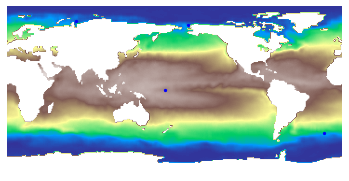

reconstruction 64799


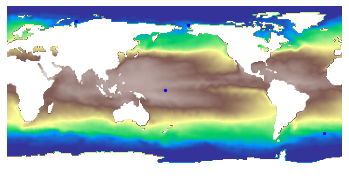

Error:  0.05509645549269464 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 10


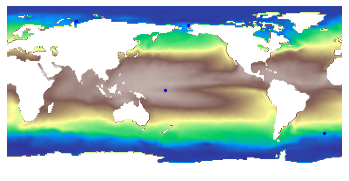

reconstruction 64799


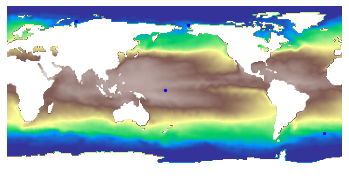

Error:  0.05436578708272454 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
shallow_decoder oprating without drop


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


reconstruction 10


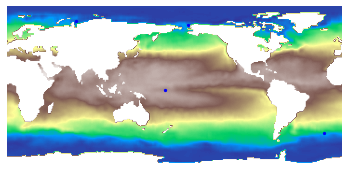

reconstruction 64799


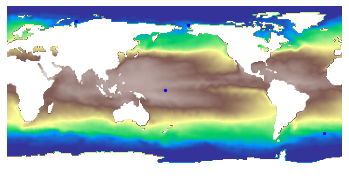

using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
Error:  0.056831982903528956 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
autoencoder oprating without dropout layer
data_type: sea_temp 
 using lstm cell
autoencoder oprating without dropout layer
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
Error:  0.05125875577855618 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
Error:  0.04991558946981039 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
shallow_decoder oprating w

In [ ]:
# del args.raw_data
def sst_mthd__snsr():
  args.data_type = 'sea_temp' 
  args.exp = 'mthd__snsr'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1300, 0.0007, 400, 100, 25, 100
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0)

  # for s in [4]:
  for s in [4, 8, 16, 32]:

      num_epochs, lr, hidden_size, seq_len, bn  = 700, 0.0006, 50, 7, 25
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0)

      num_epochs, lr, bn  = 700, 0.0007, 25
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 600, 0.0009, 1e-4
      SD_train(s, num_epochs, lr, wd)

  error = np.zeros((3, 4))
  plot_s_list = np.array([4])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([10]) 

  for s, i in zip([4, 8, 16, 32], count(0, 1)):  
    seq_len, bn, plot, save, use_stats = 7, 25, (1, 1, 0), (0, 0), 1

    er1 = ARE_test(s, seq_len, bn,
                  plot, save,
                  plot_s_list=plot_s_list, 
                  plot_seq_len_list=plot_seq_len_list,
                  plot_image_idx=plot_image_idx,
                  use_stats=use_stats)
    
    er2 = PDS_test(s, bn, plot, save,
                   plot_s_list=plot_s_list,
                   plot_image_idx=plot_image_idx,
                   use_stats=use_stats)

    er3 = SD_test(s, plot, save,
                  plot_s_list=plot_s_list,
                  plot_image_idx=plot_image_idx,
                  use_stats=use_stats)

    error[:, i] = [er1, er2, er3]

  error_path = get_path('', 'P')
  np.savetxt(osp.join(error_path, "error_{}_seq_len{}.csv".format(args.RNN, seq_len)), error, delimiter=",")

sst_mthd__snsr()

method and sensor at certain noise level

In [ ]:
def sst_mthd__snsr_with_noise():
  args.data_type = 'sea_temp' 
  args.exp = 'mthd__snsr_with_noise'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1300, 0.0007, 400, 100, 25, 100
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)

  for s in [4, 8, 16, 32]:

      num_epochs, lr, hidden_size, seq_len, bn  = 700, 0.0006, 50, 7, 25
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

      num_epochs, lr, bn  = 700, 0.0007, 25
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 600, 0.0009, 1e-4
      SD_train(s, num_epochs, lr, wd, drop=0.1)

  error = np.zeros((3, 4))
  plot_s_list = np.array([4])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([20])  
  plot_SNR = np.array([20])

  for SNR in [10, 20, 30]:  
    for s, i in zip([4, 8, 16, 32], count(0, 1)):  
      seq_len, bn, plot, save, use_stats = 7, 25, (1, 0, 0), (1, 0, 0), 1

      er1 = ARE_test(s, seq_len, bn,
                      plot, save,
                      drop=0.35, SNR=SNR,
                      plot_s_list=plot_s_list, 
                      plot_seq_len_list=plot_seq_len_list,
                      plot_image_idx=plot_image_idx,
                      plot_SNR=plot_SNR,
                      use_stats=use_stats)
        
      er2 = PDS_test(s, bn, plot, save,
                    SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR,
                    use_stats=use_stats)

      er3 = SD_test(s, plot, save,
                    drop=0.1, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR,
                    use_stats=use_stats)

      error[:, i] = [er1, er2, er3]

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_seq_len{}_SNR{}.csv".format(args.RNN, seq_len, SNR)), error, delimiter=",")

sst_mthd__snsr_with_noise()

method and bottle neck

using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
autoencoder oprating with dropout: 0.35
data_type: sea_temp 
 using lstm cell
autoencoder oprating with dropout: 0.35
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 37
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


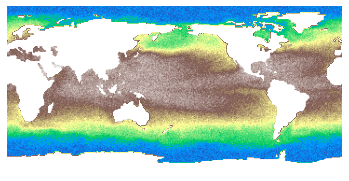

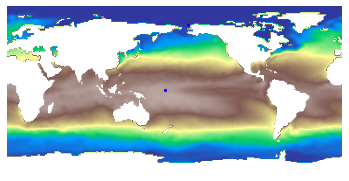

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_true_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


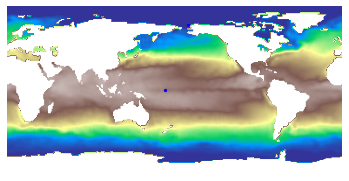

Error:  0.0840476598712562 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 40
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_sea_temp_mthd__bn_pds_s2.pdf


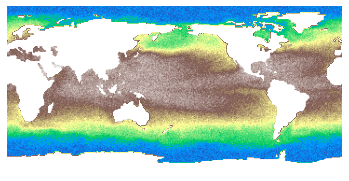

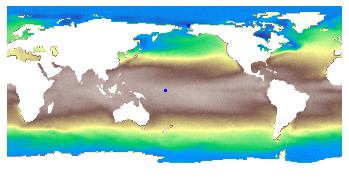

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_true_sea_temp_mthd__bn_pds_s2.pdf


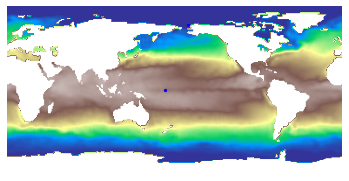

Error:  0.10352546965007495 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
autoencoder oprating with dropout: 0.35
data_type: sea_temp 
 using lstm cell
autoencoder oprating with dropout: 0.35
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 37
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


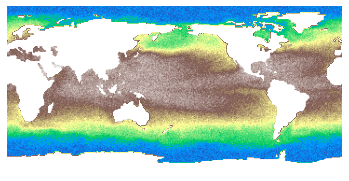

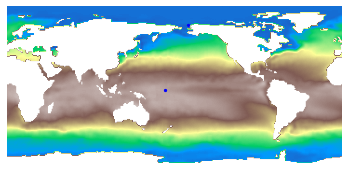

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_true_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


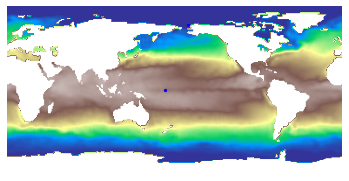

Error:  0.08477332794287495 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 40
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_sea_temp_mthd__bn_pds_s2.pdf


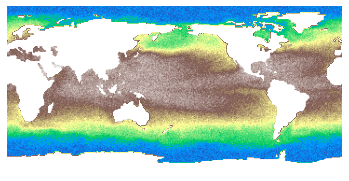

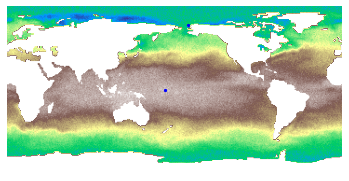

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_true_sea_temp_mthd__bn_pds_s2.pdf


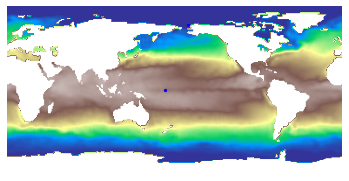

Error:  0.11539419162667207 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
autoencoder oprating with dropout: 0.35
data_type: sea_temp 
 using lstm cell
autoencoder oprating with dropout: 0.35
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 37
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


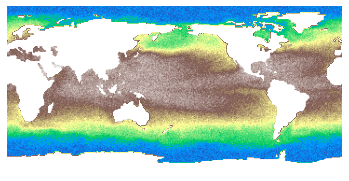

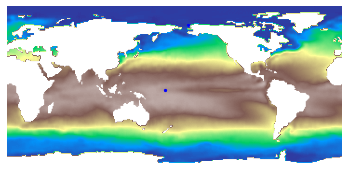

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_true_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


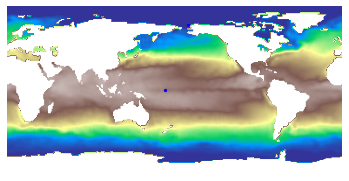

Error:  0.08012738671527317 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 40
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_sea_temp_mthd__bn_pds_s2.pdf


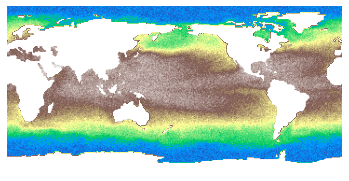

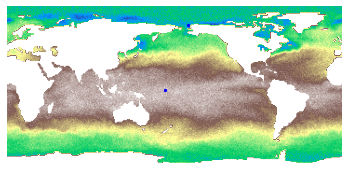

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_true_sea_temp_mthd__bn_pds_s2.pdf


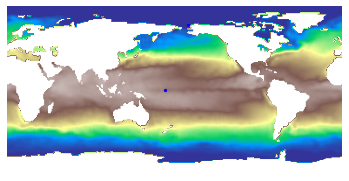

Error:  0.11612129294300662 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
autoencoder oprating with dropout: 0.35
data_type: sea_temp 
 using lstm cell
autoencoder oprating with dropout: 0.35
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 37
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


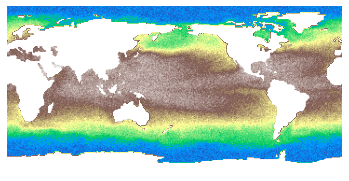

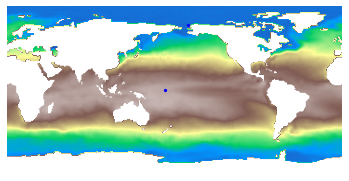

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/are/online/lstm/im_true_sea_temp_mthd__bn_are_s2_sq7_i40.pdf


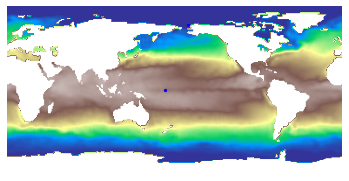

Error:  0.08072645143307901 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
reconstruction 40
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_sea_temp_mthd__bn_pds_s2.pdf


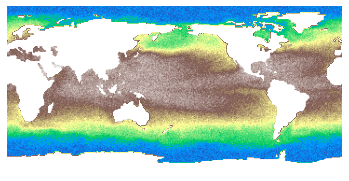

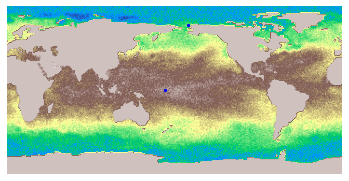

reconstruction 64799
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/sea_temp/mthd__bn/pds/im_true_sea_temp_mthd__bn_pds_s2.pdf


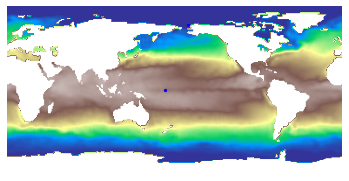

Error:  0.12219351413018234 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
autoencoder oprating with dropout: 0.35
data_type: sea_temp 
 using lstm cell
autoencoder oprating with dropout: 0.35
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
Error:  0.08341159592169463 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
using previously loaded data
in autoencoder_train_data-- no noise data
number of training samples: 400
Error:  0.10420540438368198 ------------------------------------------------
using previously loaded data
in autoencoder_train_data-- noise data SNR:  20
reconstruction 0
number of training samples: 400
autoencoder oprating with dropout: 0.35
data_type: sea_temp 
 using

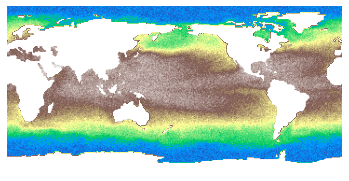

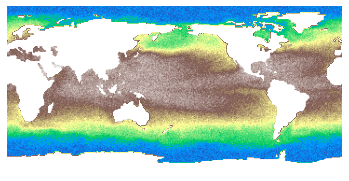

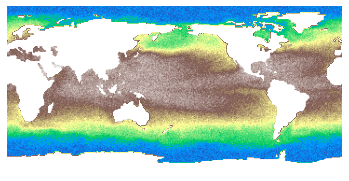

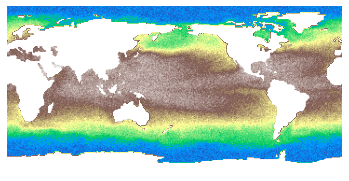

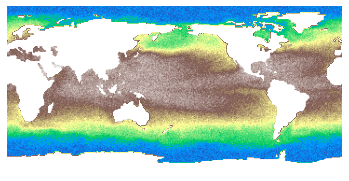

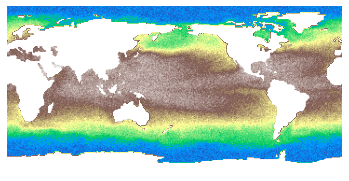

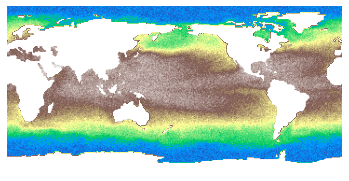

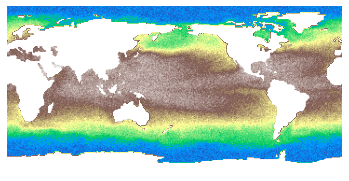

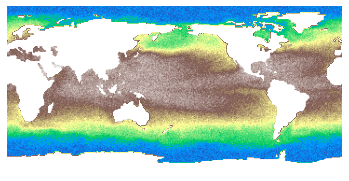

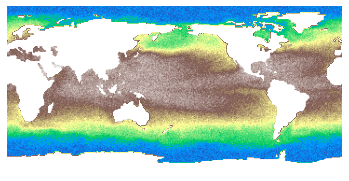

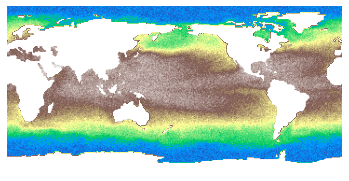

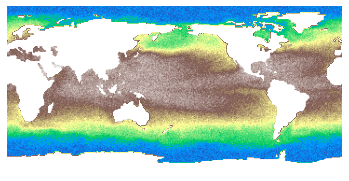

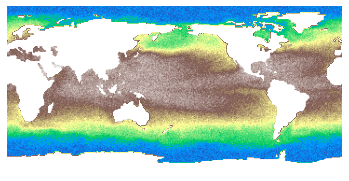

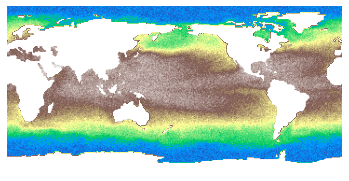

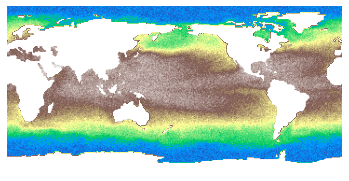

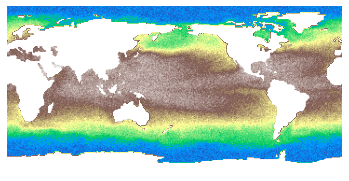

In [ ]:
def sst_mthd__bn():
  args.data_type = 'sea_temp' 
  args.exp = 'mthd__bn'

  for bn in [5, 15, 25, 50]:

    num_epochs, lr, bs, bsv, bn, early_stop  = 1300, 0.0007, 400, 100, bn, 100
    AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)

    for s in [2, 4, 8]:

      num_epochs, lr, hidden_size, seq_len, bn  = 700, 0.0006, 50, 7, bn
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

      num_epochs, lr, bn  = 700, 0.0009, bn
      PDS_train(s, bn, num_epochs, lr)

  error = np.zeros((2, 4))
  plot_s_list = np.array([2])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([40])  # 5
  plot_SNR = np.array([20])
  
  for s in [2, 4, 8]:
    for bn, i in zip([5, 15, 25, 50], count(0, 1)): 

      seq_len, bn, plot, save, use_stats, SNR = 7, bn, (1, 1, 0), (1, 1, 0), 1, 20

      er1 = ARE_test(s, seq_len, bn,
                    plot, save,
                    drop=0.35, SNR=SNR,
                    plot_s_list=plot_s_list, 
                    plot_seq_len_list=plot_seq_len_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)
      
      er2 = PDS_test(s, bn, plot, save,
                    SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)
      
      error[:, i] = [er1, er2]

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_{}.csv".format(args.RNN, s)), error, delimiter=",")


sst_mthd__bn()

method and SNR(signal to noise ratio)

In [ ]:
def sst_mthd__snr():
  args.data_type = 'sea_temp' 
  args.exp = 'mthd__snr'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1300, 0.0007, 400, 100, 25, 100
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)


  for s in [2, 4, 8]:  

      num_epochs, lr, hidden_size, seq_len, bn  = 700, 0.0006, 50, 7, 25
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

      num_epochs, lr, bn  = 700, 0.0009, 25
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 500, 0.0009, 1e-4
      SD_train(s, num_epochs, lr, wd, drop=0.1)

  SNR_range = range(5, 80, 5)
  error = np.zeros((3, len(SNR_range)))
  plot_s_list = np.array([4])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([20])
  plot_SNR = np.array([10, 70])
  
  for s in [2, 4, 8]:
    for SNR, i in zip(SNR_range, count(0, 1)):
      seq_len, bn, plot, save, use_stats = 7, 25, (0, 0, 0), (0, 0, 0), 1

      er1 = ARE_test(s, seq_len, bn,
                    plot, save,
                    drop=0.35, SNR=SNR,
                    plot_s_list=plot_s_list, 
                    plot_seq_len_list=plot_seq_len_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)
      
      er2 = PDS_test(s, bn, plot, save,
                    SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)

      er3 = SD_test(s, plot, save,
                    drop=0.1, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)

      error[:, i] = [er1, er2, er3]

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_{}.csv".format(args.RNN, s)), error, delimiter=",")

sst_mthd__snr()

sensor and sequence len.

In [ ]:
def sst_snsr__seq_len():
  args.data_type = 'sea_temp' 
  args.exp = 'snsr__seq_len'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1300, 0.0007, 400, 100, 25, 100
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)

  for s in [2, 4, 8, 16]:
    for seq_len in [5, 7, 9, 11, 13]:

        num_epochs, lr, hidden_size, s, bn  = 700, 0.0006, 50, s, 25
        ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

  error = np.zeros((5, 5))
  plot_s_list = np.array([16])
  plot_seq_len_list = np.array([0])
  plot_image_idx = np.array([20])  # 5
  plot_SNR = np.array([50])

  for SNR in [10, 20, 30]:  
    for s, j in zip([2, 4, 8, 16], count(0, 1)):
      for seq_len, i in zip([5, 7, 9, 11, 13], count(0, 1)):  
        bn, plot, save = (25, (1, 1, 0), (1, 1, 0)) if s in [4] else (25, (0, 0, 0), (0, 0, 0)) 
        print('\n no. of sensors:',s,' seq_len:',seq_len)
        
        er1 = ARE_test(s, seq_len, bn,
                       plot, save,
                       drop=0.35, SNR=SNR,
                       plot_s_list=plot_s_list, 
                       plot_seq_len_list=plot_seq_len_list,
                       plot_image_idx=plot_image_idx,
                       plot_SNR=plot_SNR)

        error[j, i] = er1

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_SNR{}.csv".format(args.RNN, SNR)), error, delimiter=",")

sst_snsr__seq_len()

# Recycle Bin

In [ ]:
def periodic_rndm_trials():
  args.data_type = 'periodic' 
  args.exp = 'rndm_trials'

  num_epochs, lr, bs, bsv, bn, early_stop  = 1200, 0.0007, 399, 133, 25, 200 
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0.35)


  for s in [1, 2]:  
    
      num_epochs, lr, hidden_size, seq_len, bn  = 2700, 0.0006, 50, 7, 25 
      ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0.35)

      num_epochs, lr, bn  = 1200, 0.0009, 25 
      PDS_train(s, bn, num_epochs, lr)

      num_epochs, lr, wd  = 1500, 0.001, 1e-4 
      SD_train(s, num_epochs, lr, wd, drop=0.1)

  SNR_range = range(16, 84, 4)
  error = np.zeros((3, len(SNR_range)))
  plot_s_list = np.array([10, 20])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([39])
  plot_SNR = np.array([20, 72])
  
  for s in [1, 2]:
    for SNR, i in zip(SNR_range, count(0, 1)):
      seq_len, bn, plot, save, use_stats = 7, 25, (0, 0, 0), (0, 0, 0), 1
      print('\n no. of sensors:',s,' SNR:',SNR)

      er1 = ARE_test(s, seq_len, bn,
                    plot, save,
                    drop=0.35, SNR=SNR,
                    plot_s_list=plot_s_list, 
                    plot_seq_len_list=plot_seq_len_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)
      
      er2 = PDS_test(s, bn, plot, save,
                    SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)

      er3 = SD_test(s, plot, save,
                    drop=0.1, SNR=SNR,
                    plot_s_list=plot_s_list,
                    plot_image_idx=plot_image_idx,
                    plot_SNR=plot_SNR)

      error[:, i] = [er1, er2, er3]

    error_path = get_path('', 'P')
    np.savetxt(osp.join(error_path, "error_{}_{}.csv".format(args.RNN, s)), error, delimiter=",")

periodic_rndm_trials()

## Turbulence

method and sensors

In [ ]:
def turbulence_mthd__snsr():
  args.data_type = 'turbulence' 
  args.exp = 'mthd__snsr'

  # num_epochs, lr, bs, bsv, bn, early_stop = 1200, 0.0006, 1000, 400, 50, 300 
  # AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0)


  # for s in [32*32]:

  #     num_epochs, lr, hidden_size, seq_len, bn  = 700, 0.0006, 50, 7, 25
  #     ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0)

  #     num_epochs, lr, bn  = 700, 0.0009, 25
  #     PDS_train(s, bn, num_epochs, lr)

  #     num_epochs, lr, wd  = 600, 0.0009, 1e-4
  #     SD_train(s, num_epochs, lr, wd)

  error = np.zeros((3, 1))
  plot_s_list = np.array([32*32])
  plot_seq_len_list = np.array([7])
  plot_image_idx = np.array([0])  # 5

  for s, i in zip([32*32], count(0, 1)):  
    seq_len, bn, plot, save = 7, 25, (1, 1, 0), (1, 1, 0)

    er1 = ARE_test(s, seq_len, bn,
                  plot, save,
                  plot_s_list=plot_s_list, 
                  plot_seq_len_list=plot_seq_len_list,
                  plot_image_idx=plot_image_idx)
    
    er2 = PDS_test(s, bn, plot, save,
                   plot_s_list=plot_s_list,
                   plot_image_idx=plot_image_idx)

    er3 = SD_test(s, plot, save,
                  plot_s_list=plot_s_list,
                  plot_image_idx=plot_image_idx)

    error[:, i] = [er1, er2, er3]

  error_path = get_path('', 'P')
  np.savetxt(osp.join(error_path, "error_{}.csv".format(args.RNN)), error, delimiter=",")

turbulence_mthd__snsr()

method and training samples

using previously loaded data
number of training samples: 3500
without_drop
(0) Training Loss: 0.99525195 NEW Valid Loss: 0.53828186 *
(1) Training Loss: 0.81785136 NEW Valid Loss: 0.46174866 *
(2) Training Loss: 0.59880912 NEW Valid Loss: 0.43673193 *
(3) Training Loss: 0.49685484 NEW Valid Loss: 0.43451479 *
(4) Training Loss: 0.46030447 NEW Valid Loss: 0.42804328 *
(5) Training Loss: 0.43669778 NEW Valid Loss: 0.42181182 *
(6) Training Loss: 0.40724048 NEW Valid Loss: 0.41321638 *
(7) Training Loss: 0.37540084 NEW Valid Loss: 0.40175825 *
(8) Training Loss: 0.34893897 NEW Valid Loss: 0.39637843 *
(9) Training Loss: 0.32530776 NEW Valid Loss: 0.39324343 *
(10) Training Loss: 0.30343992 NEW Valid Loss: 0.38979617 *
(11) Training Loss: 0.28227332 NEW Valid Loss: 0.37897620 *
(12) Training Loss: 0.26317629 NEW Valid Loss: 0.36450663 *
(13) Training Loss: 0.24564162 NEW Valid Loss: 0.35280216 *
(14) Training Loss: 0.23019379 NEW Valid Loss: 0.34531921 *
(15) Training Loss: 0.21669362 NEW 

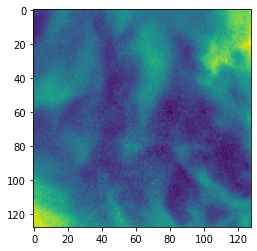

reconstruction 0
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/turbulence/mthd__tr_samp/are/autoencoder/tr_samp3500/best_train_in.pdf


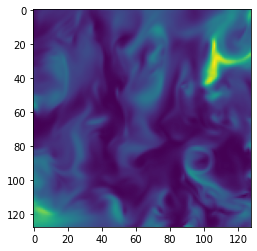

reconstruction 0
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/turbulence/mthd__tr_samp/are/autoencoder/tr_samp3500/best_valid_out.pdf


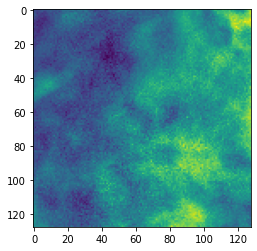

reconstruction 0
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/turbulence/mthd__tr_samp/are/autoencoder/tr_samp3500/best_valid_in.pdf


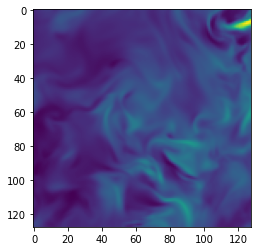

==========weights saved==========
================================ over ================================
using previously loaded data
number of training samples: 4000
without_drop
(0) Training Loss: 0.99537224 NEW Valid Loss: 0.90736639 *
(1) Training Loss: 0.81837076 NEW Valid Loss: 0.87483031 *
(2) Training Loss: 0.62036586 NEW Valid Loss: 0.84615910 *
(3) Training Loss: 0.52283031 NEW Valid Loss: 0.82028997 *
(4) Training Loss: 0.48035479 NEW Valid Loss: 0.80194181 *
(5) Training Loss: 0.45530561 NEW Valid Loss: 0.79586285 *
(6) Training Loss: 0.42552930 NEW Valid Loss: 0.78805929 *
(7) Training Loss: 0.39186731 NEW Valid Loss: 0.77755064 *
(8) Training Loss: 0.36324129 NEW Valid Loss: 0.76261765 *
(9) Training Loss: 0.33976153 NEW Valid Loss: 0.74639493 *
(10) Training Loss: 0.31938720 NEW Valid Loss: 0.73864156 *
(11) Training Loss: 0.30223402 NEW Valid Loss: 0.73402953 *
(12) Training Loss: 0.28217626 NEW Valid Loss: 0.72354460 *
(13) Training Loss: 0.26437664 NEW Valid Loss: 0.7

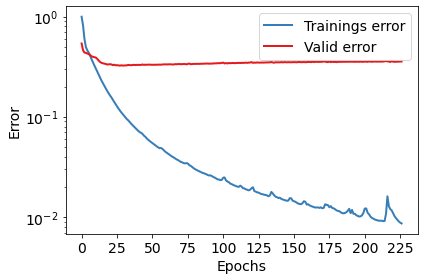

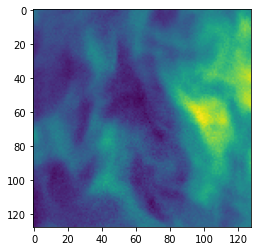

reconstruction 0
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/turbulence/mthd__tr_samp/are/autoencoder/tr_samp4000/best_train_in.pdf


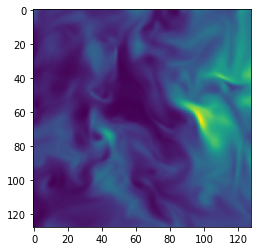

reconstruction 0
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/turbulence/mthd__tr_samp/are/autoencoder/tr_samp4000/best_valid_out.pdf


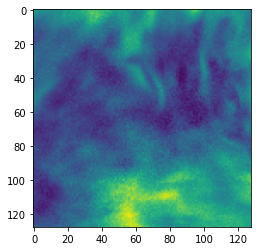

reconstruction 0
SAVED == ../content/drive/My Drive/Colab Notebooks/are/weights_results/turbulence/mthd__tr_samp/are/autoencoder/tr_samp4000/best_valid_in.pdf


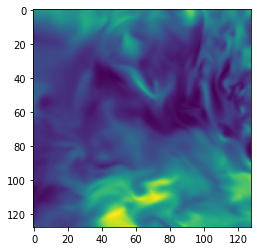

==========weights saved==========
================================ over ================================


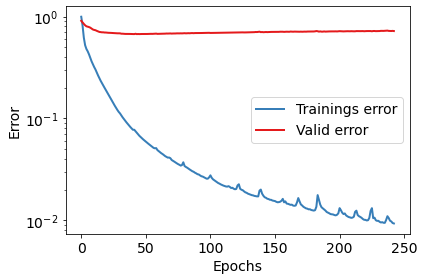

In [ ]:
args.data_type = 'turbulence'
args.exp = 'mthd__tr_samp'

for args.tr_samp in range(3500, 4001, 500):

  num_epochs, lr, bs, bsv, bn, early_stop = 1500, 0.0006, 1000, 400, 50, 200
  AutoEcoder(bn, lr, num_epochs, bs, bsv, early_stop, drop=0) 

  # num_epochs, lr, hidden_size, seq_len, bn  = 2700, 0.0006, 50, 7, 25
  # ARE_train_LSTM(s, seq_len, bn, hidden_size, num_epochs, lr, drop=0)

  # num_epochs, lr, bn  = 1200, 0.0009, 25
  # PDS_train(s, bn, num_epochs, lr)

  # num_epochs, lr, wd  = 12, 0.0009, 1e-4
  # SD_train(s, num_epochs, lr, wd)

del args.tr_samp

In [ ]:
""" testing sensor locations in get_data() """

#####################################              

      recon = np.ones((m*n))*35
      for i, j in zip(args.sea_idx, count(0, 1)):
        recon[i] = args.raw_data[0][j]

      idices = np.arange(0, 44219)
      np.random.seed(323)  # changing seed will change the postion of sensors and networks will have to be retrained
      s_idx_in_flatten = np.random.choice(idices, 500, False)

      flat_sea_mask = np.zeros((44219))
      flat_sea_mask[s_idx_in_flatten] = 1
      # flat_sea_mask = np.ones((44219))
      flat_mask = np.zeros((m*n))
      for i, j in zip(args.sea_idx, count(0, 1)):
        flat_mask[i] = flat_sea_mask[j]

      mask = flat_mask.reshape(n, m)
      cords = np.where(mask == 1)
      cords = np.asarray(cords)

      recon = np.ones((m*n))*35
      for i, j in zip(args.sea_idx, count(0, 1)):
        recon[i] = args.raw_data[0][j]

      recon_im = recon.reshape(n, m)
      
      plt.figure()
      plt.imshow(recon_im, cmap='terrain')
      plt.gca().invert_yaxis()
      plt.scatter(cords[1], cords[0], marker='.', color='b', s=5, zorder=5) if cords.any() else 0
      
      
      plt.show()
      plt.close()

      
      
      pdb.set_trace()
      ######################################